In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime as dt
import pylab as pl

from sklearn.cross_validation import cross_val_score 
from sklearn.cross_validation import KFold
import sklearn.preprocessing as pp
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import Lasso
from sklearn.decomposition import RandomizedPCA
from sklearn.linear_model import Ridge
from sklearn import metrics
from sklearn import cross_validation
from sklearn.datasets import load_digits
from sklearn.learning_curve import learning_curve
import sklearn.decomposition
import sklearn.ensemble as sk
from sklearn import linear_model
from sklearn.svm import LinearSVR
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import cross_val_predict


import random
import sys
from scipy import stats
% matplotlib inline
%load_ext autoreload
%autoreload 2
from regression_functions import *
from reg_plots import *


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Import Data

In [12]:
pod_number = 'cham_3'

In [17]:
df_all = pd.io.parsers.read_csv(filepath_or_buffer = 'data/cham3_coll_feat.csv', parse_dates = [0], index_col = 0)
df_all = df_all.rename(columns={'e2v03': 'O3_ppb'})

#### Declare whether to process raw or filtered data.

In [18]:
which_data = 0    #1 = filtered, 0 = raw
ref_column, leave_out_pod, pod_ozone = declare_filt_or_raw_dataset(which_data)

#### Call the scaling function and create a dataframe with scaled data.

In [19]:
df_scaled, features, minmax_scale_fit, standard_scale_fit = scale_features_and_create_day_column(df_all, ref_column)
len(df_scaled)

77884

#### Declare whether you'd like to use holdout dates from a previous run.

In [22]:
prev_holdout = "false"
chunks = ['7-26 PM', '7-28 AM', '8-5 PM', '8-7 AM']

#### Add a 'day' column to the dataframe, and separate the data into training and holdout.

In [23]:
if prev_holdout == "true":
    df_tr, df_hold, chunks_tr, days_tr = sep_tr_and_holdout_pre_defined(df_scaled, ref_column, chunks)
else:
    df_tr, df_hold, chunks_tr, days_tr = sep_tr_and_holdout(df_scaled, ref_column)

['7-17 PM' '7-18 AM' '7-21 PM' '7-22 AM' '7-22 PM' '7-23 AM' '7-23 PM'
 '7-24 AM' '7-24 PM' '7-25 AM']


In [24]:
df_hold['chunk'].unique()

array(['7-23 AM', '7-23 PM', '7-24 PM', '7-25 AM'], dtype=object)

#### Declare a cutoff value for 'high' ozone.

In [25]:
cutoff_value = 50

#### Plot the pod ozone, ref ozone, temp and RH.

KeyError: 'e2v03'

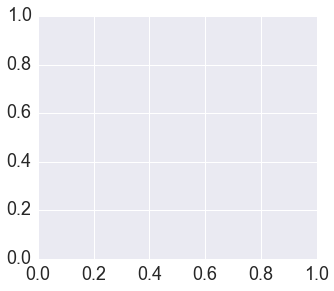

In [26]:
plot_03_temp_rh_no_scale(df_all, pod_number, ref_column, 'Training Data', cutoff_value, 5)

#### Plot the training ozone

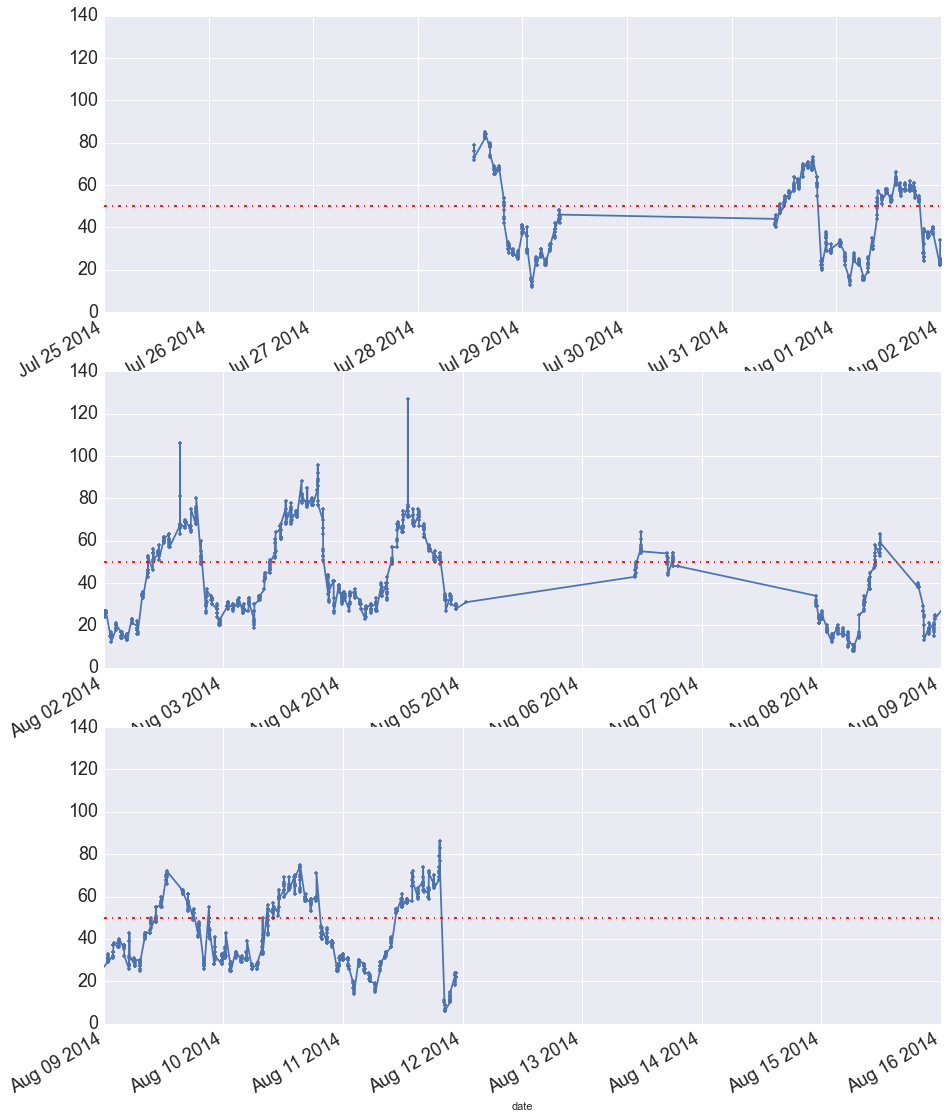

In [11]:
plot_tr_and_holdout(df_tr, pod_number, ref_column, 'Training Data', cutoff_value)

###Plot holdout ozone to make sure that the holdout set has some high-value ozone measurements.

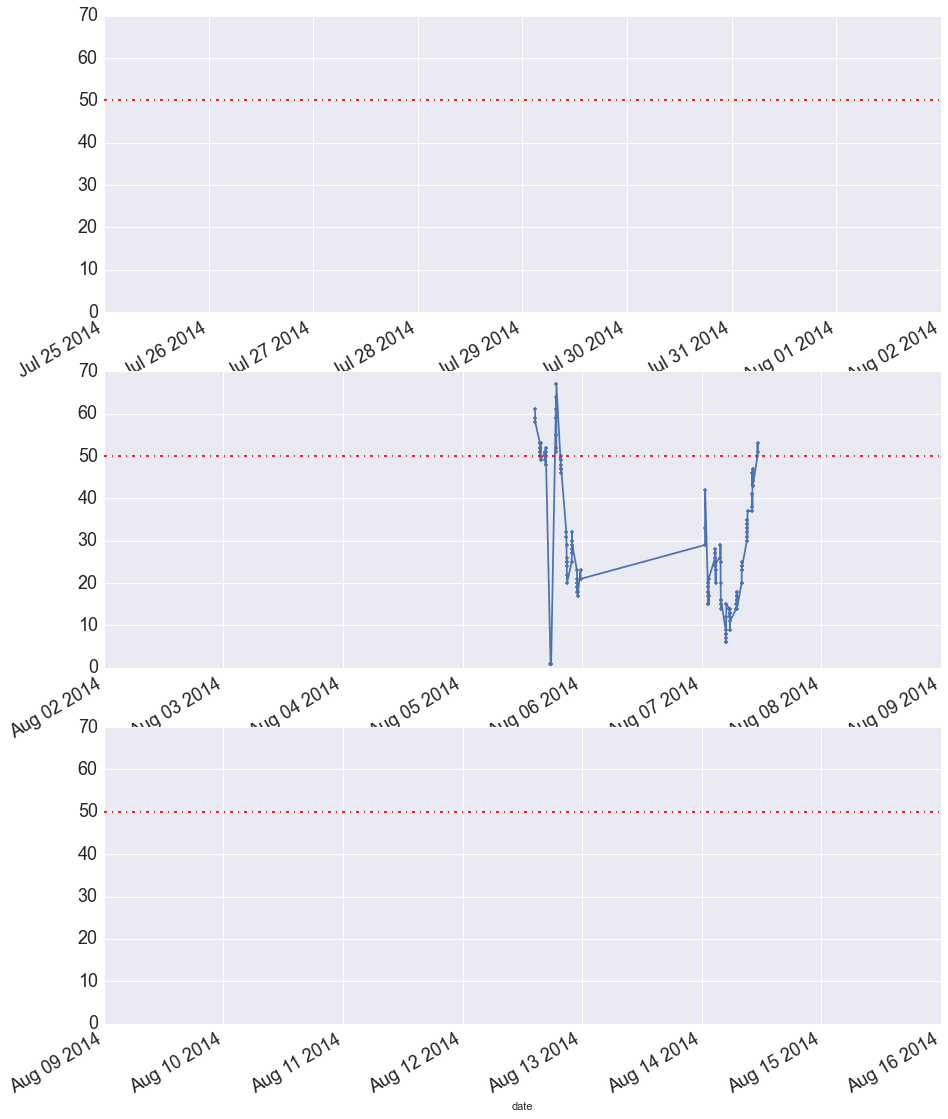

In [12]:
plot_tr_and_holdout(df_hold, pod_number, ref_column, 'Holdout Data', cutoff_value)

#### Declare a multiplication factor for the MSE part of the custom score function.

In [13]:
cust_mse_fact = 1

#### Linear Regression with Base Features

In [14]:
base_features = [pod_ozone,'Temp','Rh', 'no2']

/Users/berkeleyalmand/anaconda/lib/python2.7/site-packages/seaborn/linearmodels.py:1283: UserWarning: The `corrplot` function has been deprecated in favor of `heatmap` and will be removed in a forthcoming release. Please update your code.
  warnings.warn(("The `corrplot` function has been deprecated in favor "
/Users/berkeleyalmand/anaconda/lib/python2.7/site-packages/seaborn/linearmodels.py:1349: UserWarning: The `symmatplot` function has been deprecated in favor of `heatmap` and will be removed in a forthcoming release. Please update your code.
  warnings.warn(("The `symmatplot` function has been deprecated in favor "


/Users/berkeleyalmand/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


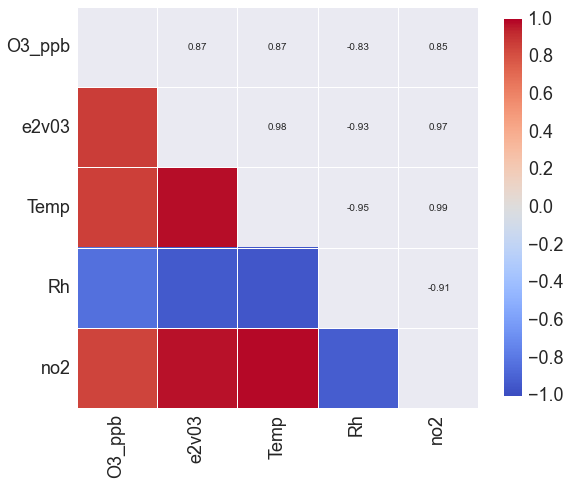

In [15]:
f, ax = plt.subplots(figsize=(9, 9))
sns.corrplot(df_tr[[ref_column] + base_features], annot=True, sig_stars=False,
             diag_names=False, ax=ax)

In [16]:
#Define the model.
lin_regr = linear_model.LinearRegression()
#find the MSE
MSE_CV, MSE_T, MSE_H, high_MSE_cv, X_pred_cv_base, y_cv, df_cv_lin_base, df_H_lin_base = cross_validation_by_day(lin_regr, base_features, df_tr, df_hold, days_tr, ref_column, cutoff_value)

Training RMSE: 9.0
Cross-Validation RMSE: 10.0 , High-Value CV RMSE: 12.0 , CV High Diff. in Mean (>50): -3.3
Holdout RMSE: 15.0 , High-Value Holdout RMSE: 11.0 , Holdout High Diff. in Mean.: -10.1


/Users/berkeleyalmand/anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


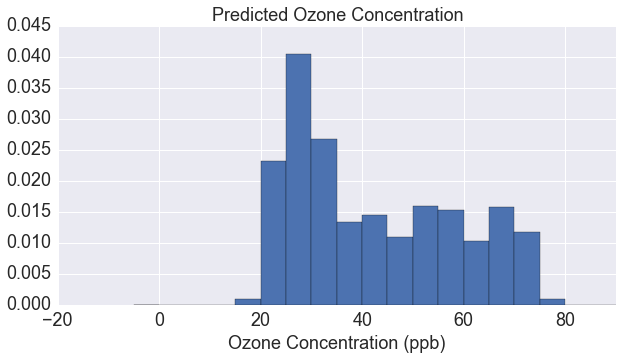

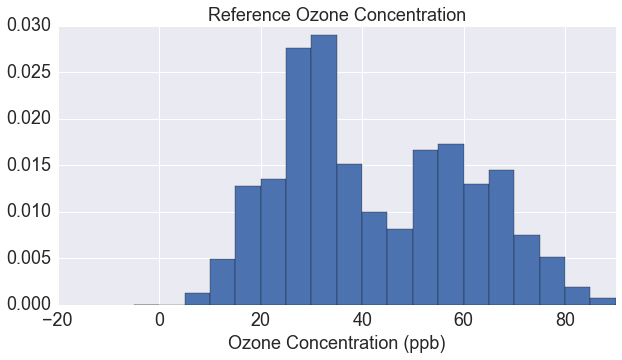

In [90]:
plot_hist(X_pred_cv_base, y_cv, 'Predicted Ozone Concentration')
plot_hist(y_cv, X_pred_cv_base, 'Reference Ozone Concentration')

#### Plot the learning curve for a linear regression with the base features.

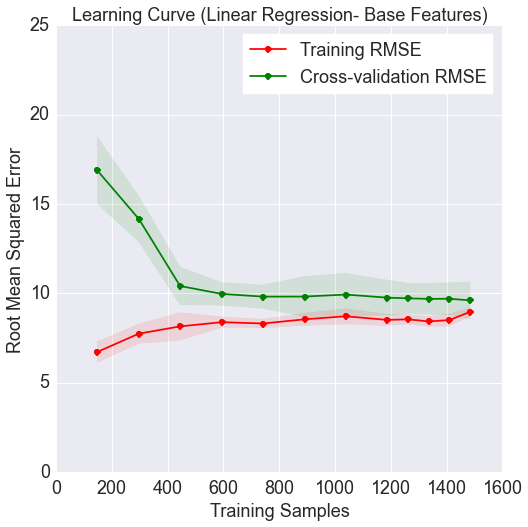

In [91]:
plt = plot_learning_curve(lin_regr, "Learning Curve (Linear Regression- Base Features)", df_tr[base_features].values, df_tr[ref_column].values, (0,25), days_tr, np.array([ 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95, 1.0]))

The MSE is high for the cross-validation set in this plot, and the training and cross-validation scores come together in this plot tells us that we have resonably high bias. Create more features and add polynomial effects to reduce bias. 

#### Plot the residuals and comparison curves.

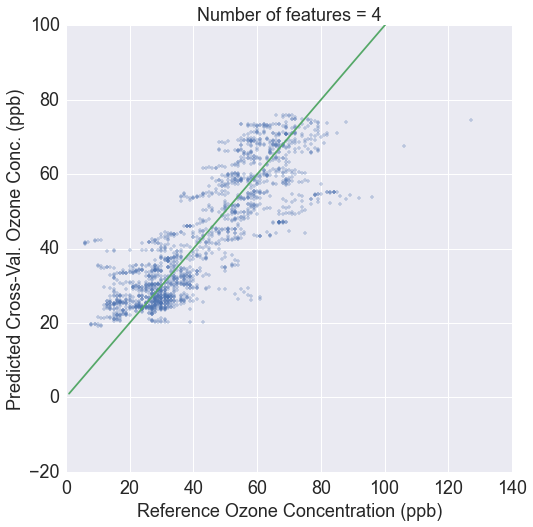

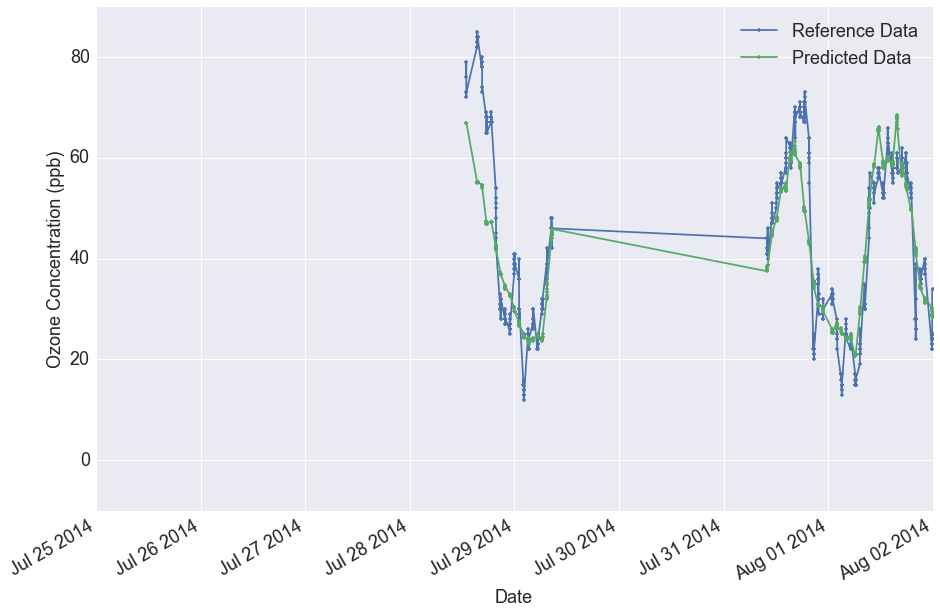

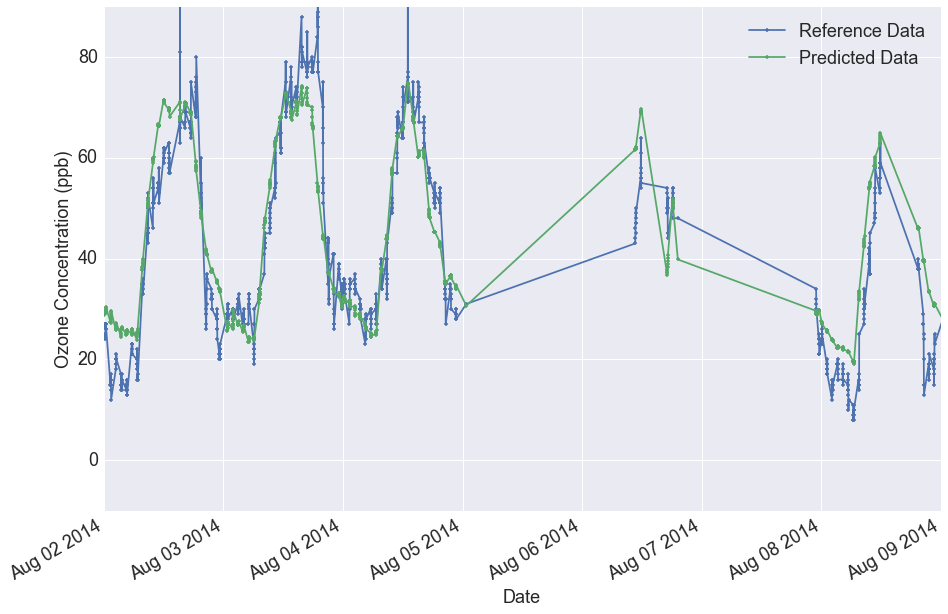

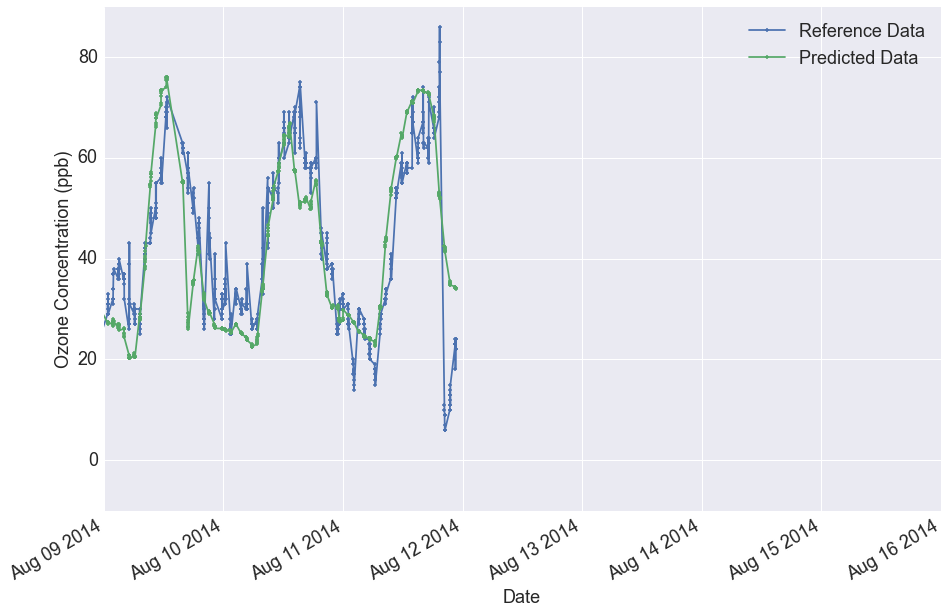

In [92]:
num_good_feat = len(base_features)
fitted_vs_ref_plot(df_cv_lin_base, num_good_feat, ref_column)
plot_fitted_and_ref_vs_time(df_cv_lin_base, pod_number, 1, ref_column)
plot_fitted_and_ref_vs_time(df_cv_lin_base, pod_number, 2, ref_column)
plot_fitted_and_ref_vs_time(df_cv_lin_base, pod_number, 3, ref_column)

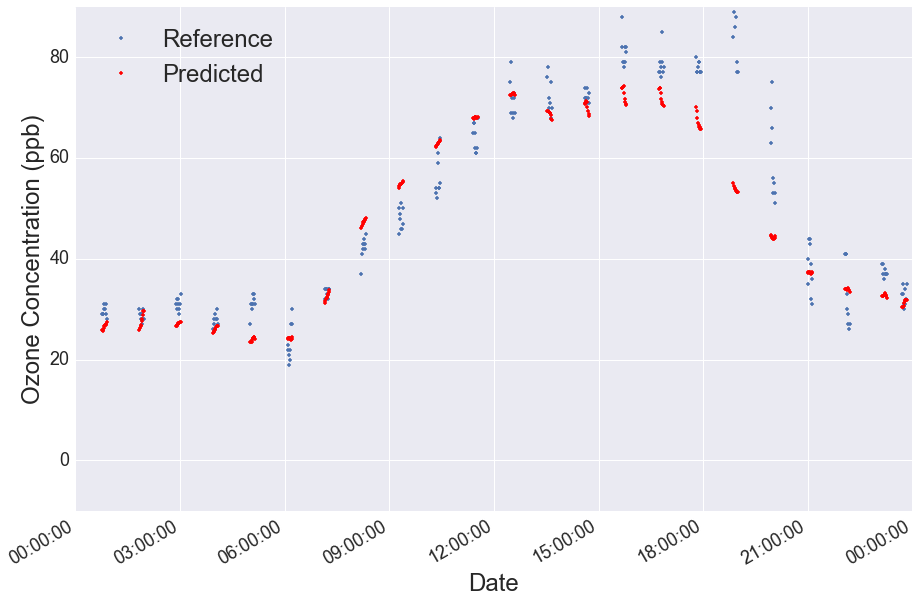

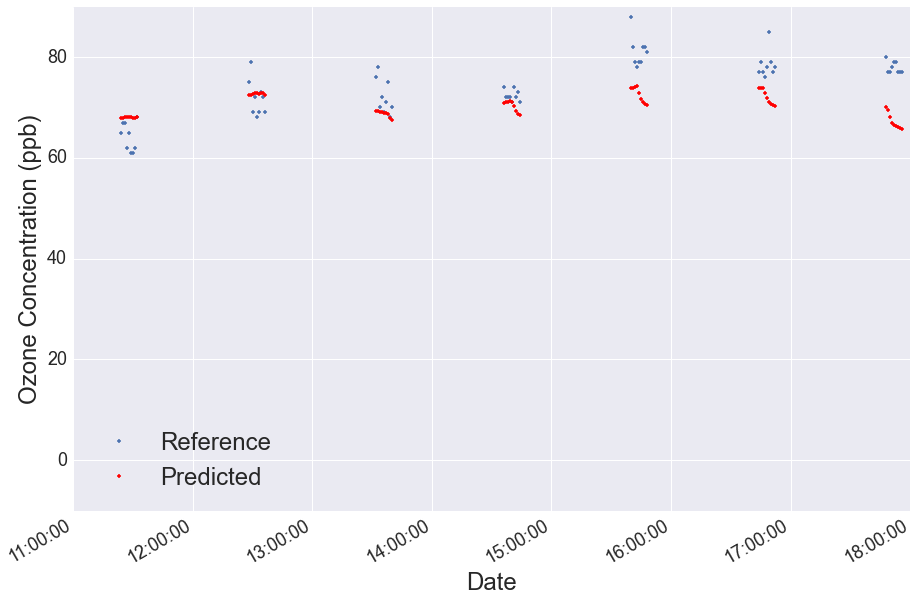

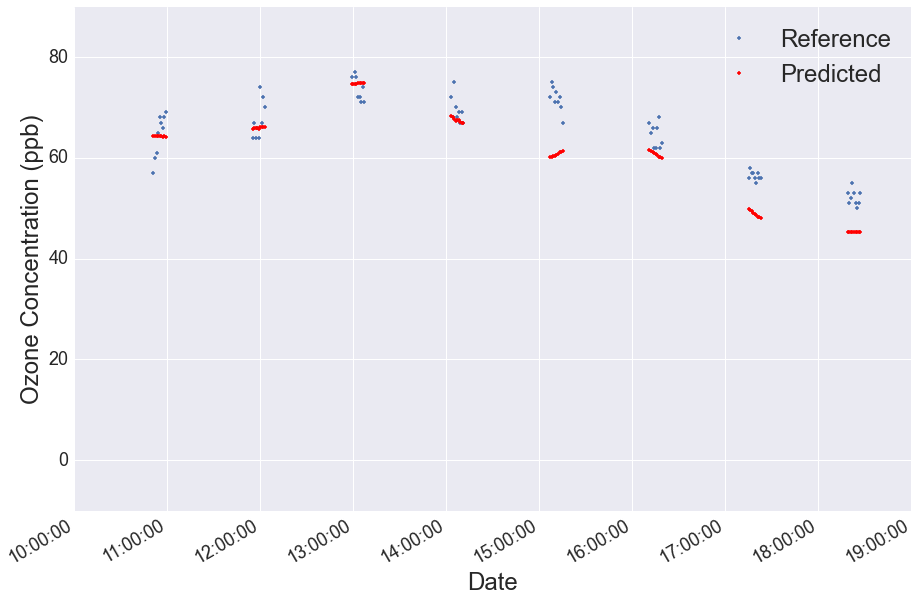

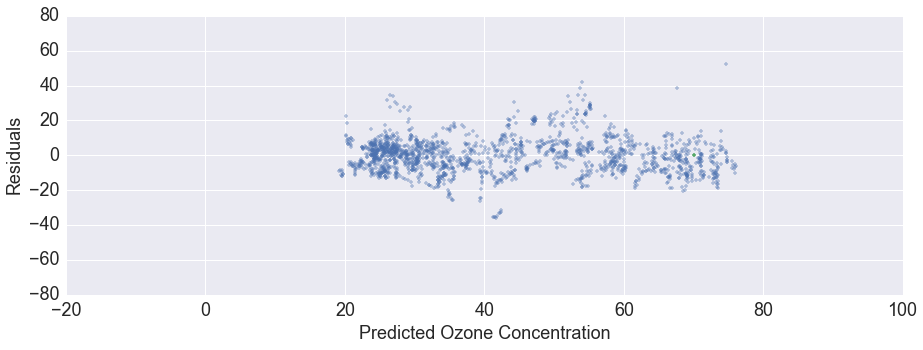

In [17]:
plot_fitted_and_ref_vs_time_no_lines(df_cv_lin_base, pod_number, 4, ref_column)
plot_fitted_and_ref_vs_time_no_lines(df_cv_lin_base, pod_number, 5, ref_column)
plot_fitted_and_ref_vs_time_no_lines(df_cv_lin_base, pod_number, 6, ref_column)
resid = plot_resid_vs_conc(df_cv_lin_base, ref_column)

#Linear Regression with All Features.

In [18]:
every_feature = list(df_tr.ix[:,0:len(df_scaled.columns)])
leave_out = ['ref_o3_smooth', 'chunk', 'day', 'O3_ppb', 'UnixTime']
all_features = [f for f in every_feature if f not in leave_out]
MSE_CV, MSE_T, MSE_H, high_MSE_cv, X_pred_cv_all, y_cv, df_cv_lin_all, df_H_lin_all = cross_validation_by_day(lin_regr, all_features, df_tr, df_hold, days_tr, ref_column, cutoff_value)

Training RMSE: 6.5
Cross-Validation RMSE: 9.0 , High-Value CV RMSE: 11.0 , CV High Diff. in Mean (>50): -2.7
Holdout RMSE: 16.0 , High-Value Holdout RMSE: 8.0 , Holdout High Diff. in Mean.: -5.8


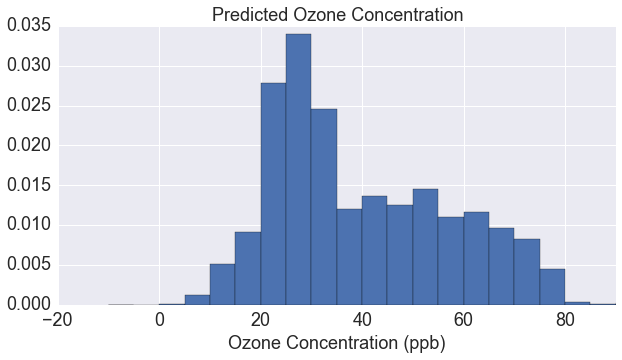

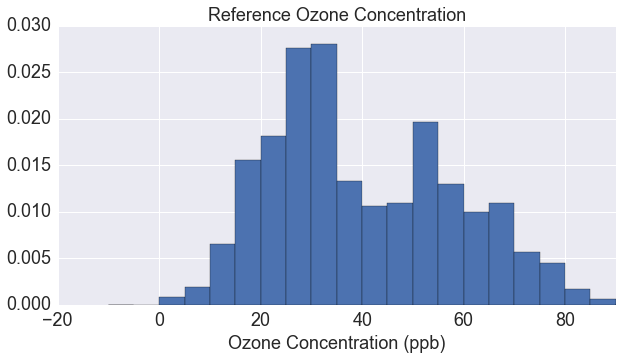

In [22]:
plot_hist(X_pred_cv_all, y_cv, 'Predicted Ozone Concentration')
plot_hist(y_cv, X_pred_cv_all, 'Reference Ozone Concentration')

#### Plot the residuals and comparison curves.

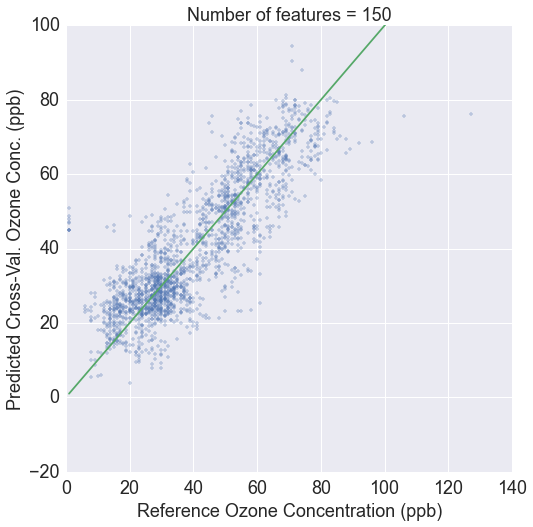

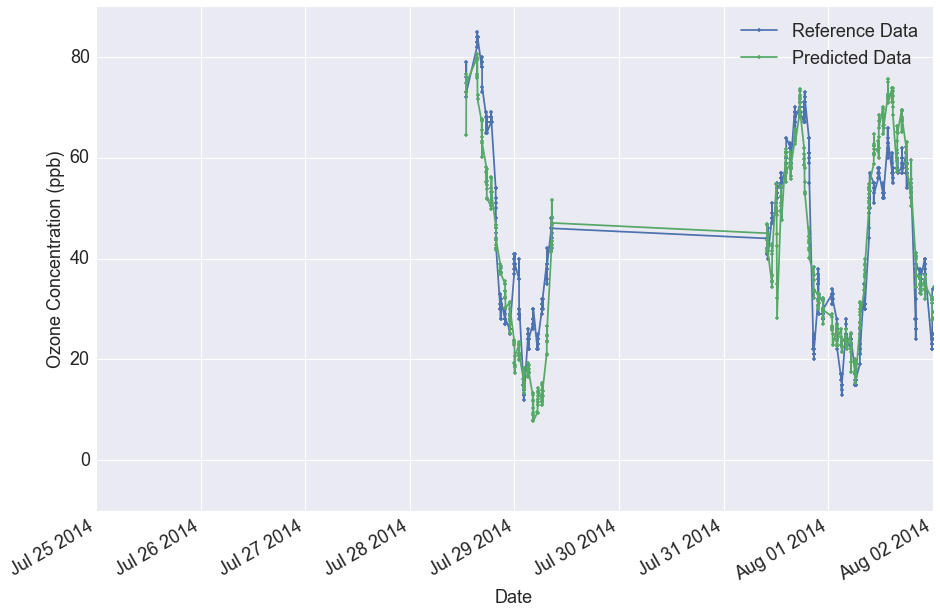

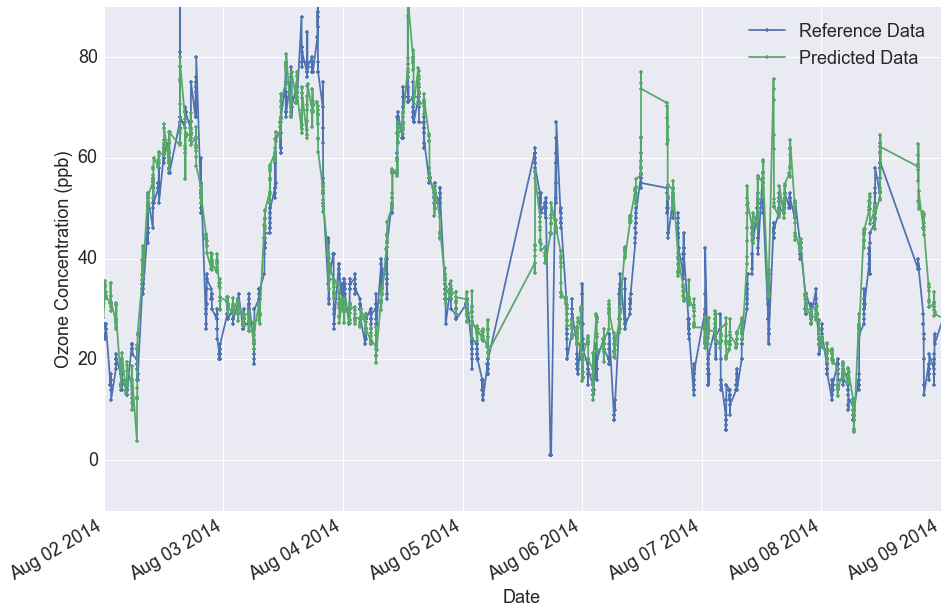

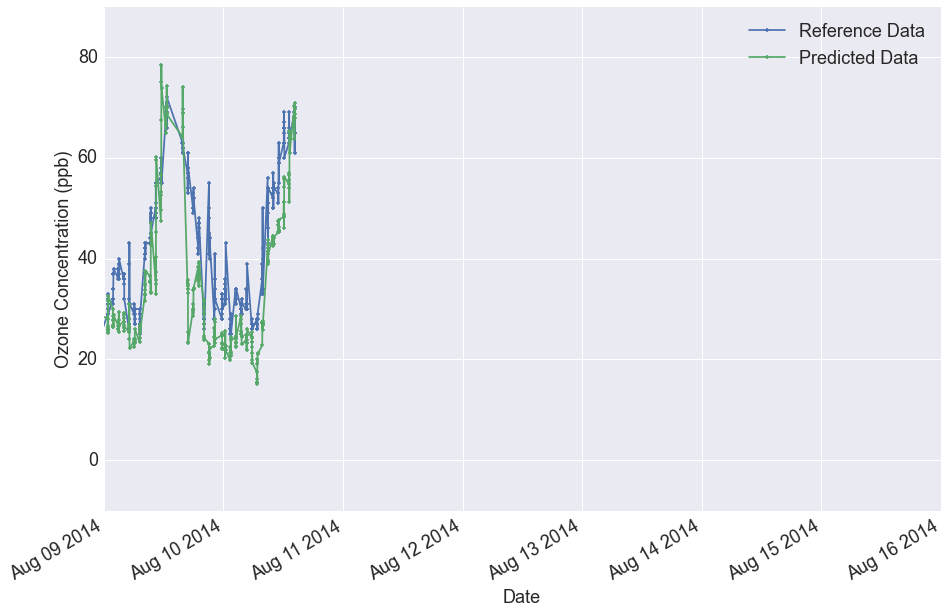

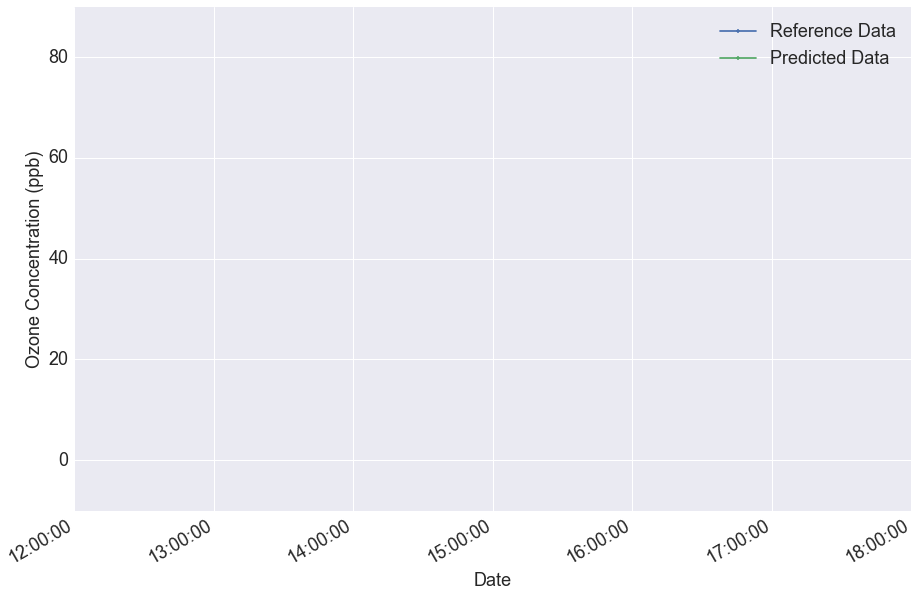

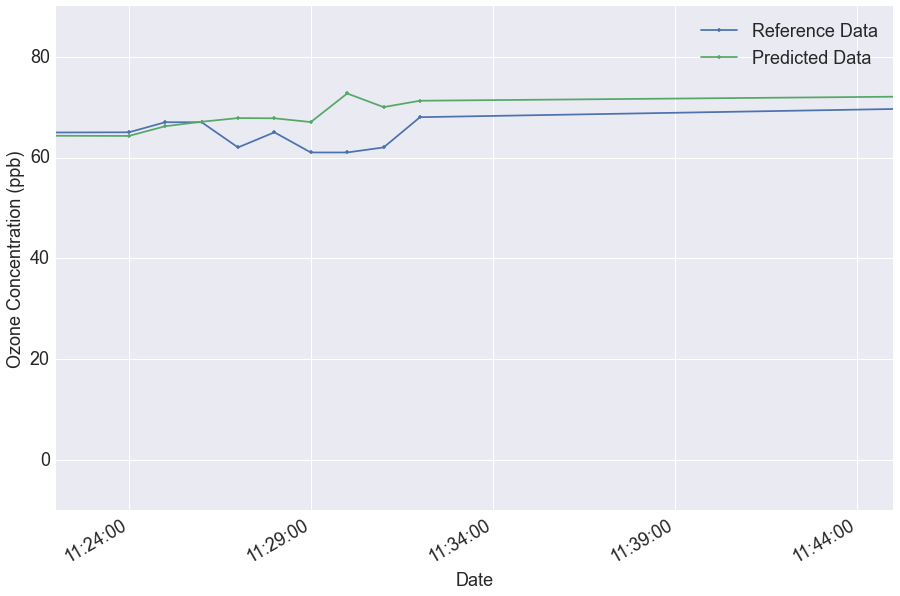

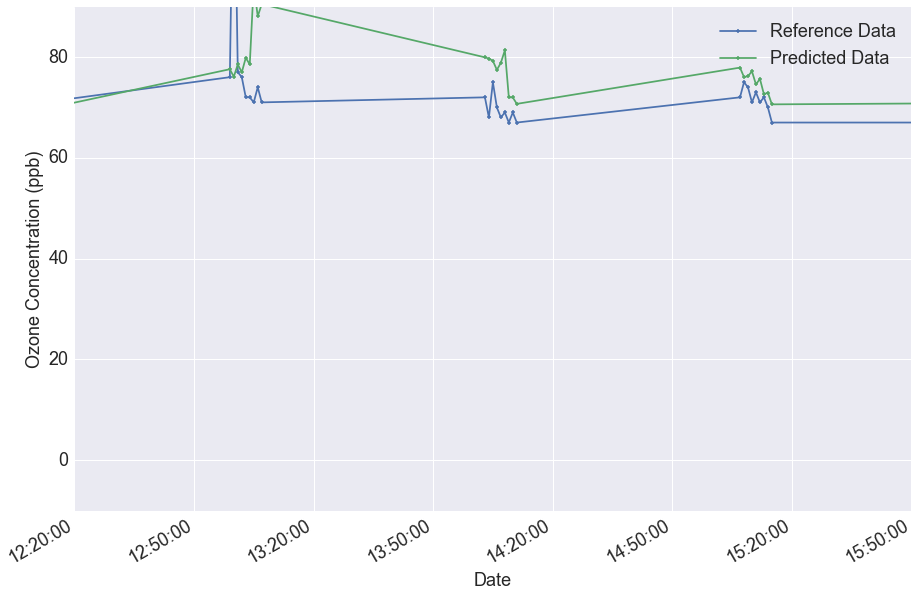

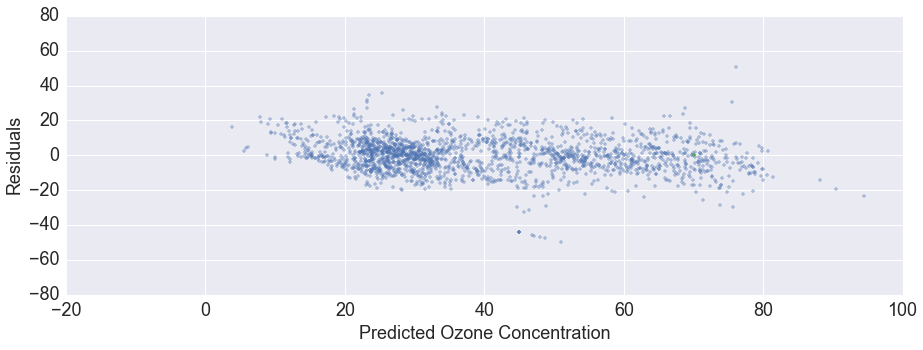

In [23]:
num_good_feat = len(all_features)
fitted_vs_ref_plot(df_cv_lin_all, num_good_feat, ref_column)
plot_fitted_and_ref_vs_time(df_cv_lin_all, pod_number, 1, ref_column)
plot_fitted_and_ref_vs_time(df_cv_lin_all, pod_number, 2, ref_column)
plot_fitted_and_ref_vs_time(df_cv_lin_all, pod_number, 3, ref_column)
plot_fitted_and_ref_vs_time(df_cv_lin_all, pod_number, 4, ref_column)
plot_fitted_and_ref_vs_time(df_cv_lin_all, pod_number, 5, ref_column)
plot_fitted_and_ref_vs_time(df_cv_lin_all, pod_number, 6, ref_column)
resid = plot_resid_vs_conc(df_cv_lin_all, ref_column)

## Forward Selection

#### Declare rather you want to use MSE or a custom error function:

In [24]:
#make a list of features from the column titles in the dataframe
features_all = list(df_tr.columns)
leave_out = ['Zenith Angle [degrees]','UnixTime', 'pod_o3_smooth', 'O3_ppb', 'ref_o3_smooth', ref_column, 'chunk']
features = [f for f in features_all if f not in leave_out]
features_it = [f for f in features if f not in 'day']
fs_features, score, RMSE = forward_selection_lodo(lin_regr, features_it, df_tr[[ref_column] + features].dropna(), 'custom_mse', ref_column, days_tr, 15, cust_mse_fact, cutoff_value)

9223372036854775807
Next best Feature:  ln_O3_int_lag_5 , Score:  9.9 RMSE:  3.7 #: 1
9223372036854775807
Next best Feature:  rh_cu , Score:  9.6 RMSE:  2.1 #: 2
9223372036854775807
Next best Feature:  ln_rh_int_lag_3 , Score:  9.3 RMSE:  2.2 #: 3
9223372036854775807
Next best Feature:  e2v03_slope_lag_5 , Score:  9.2 RMSE:  2.3 #: 4
9223372036854775807
Next best Feature:  Temp_slope_lag_3 , Score:  9.1 RMSE:  3.2 #: 5
9223372036854775807
Next best Feature:  Temp_slope_lag_4 , Score:  9.1 RMSE:  85.6 #: 6
9223372036854775807
Next best Feature:  rh_sq , Score:  9.1 RMSE:  5.5 #: 7
9223372036854775807
Next best Feature:  ln_rh_int_lead_2 , Score:  9.0 RMSE:  14.9 #: 8
9223372036854775807
Next best Feature:  ln_temp_slope_lead_2 , Score:  8.9 RMSE:  166.5 #: 9
9223372036854775807
Next best Feature:  ln_temp , Score:  8.9 RMSE:  132.5 #: 10
9223372036854775807
Next best Feature:  03_mult_rh_&_temp , Score:  8.8 RMSE:  396.2 #: 11
9223372036854775807
Next best Feature:  Rh_slope_lead_5 , Sc

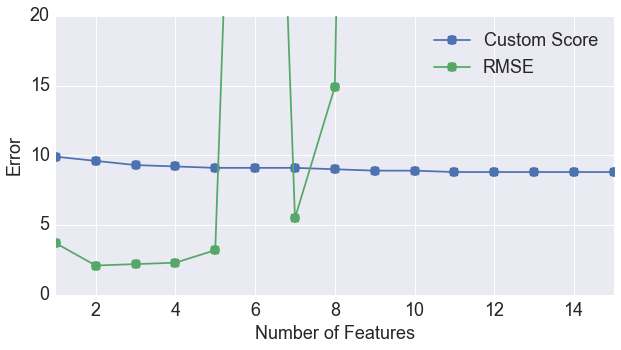

In [25]:
plot_error_vs_features(score, RMSE, [0,20], [1,15])

#### Check Residuals

#### Plot cross-validation fitted data versus reference data, and choose number of features.

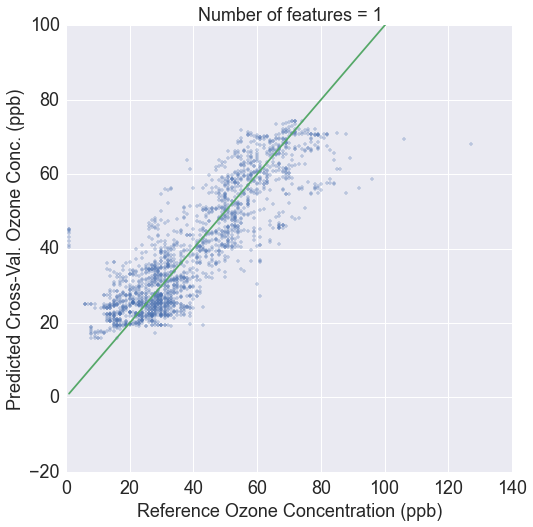

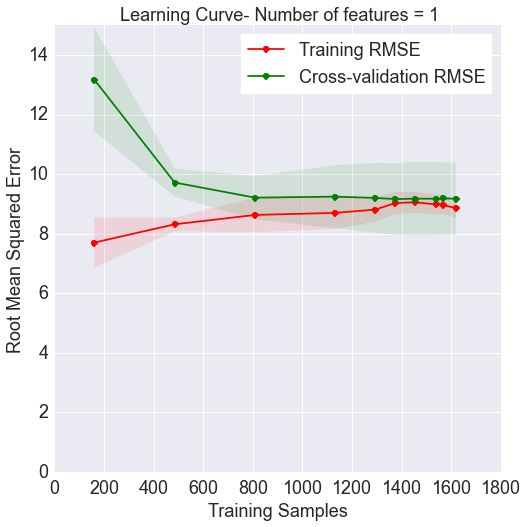

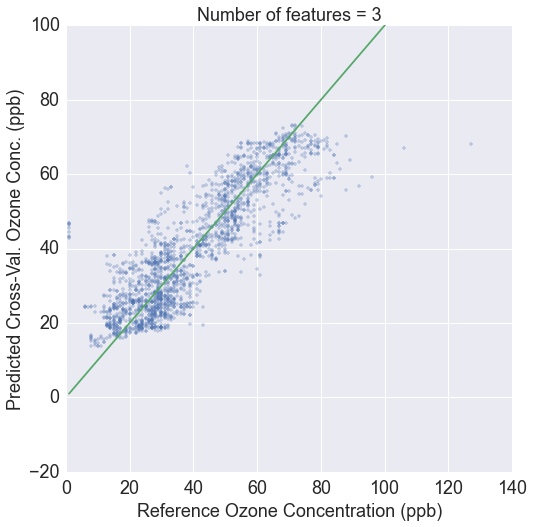

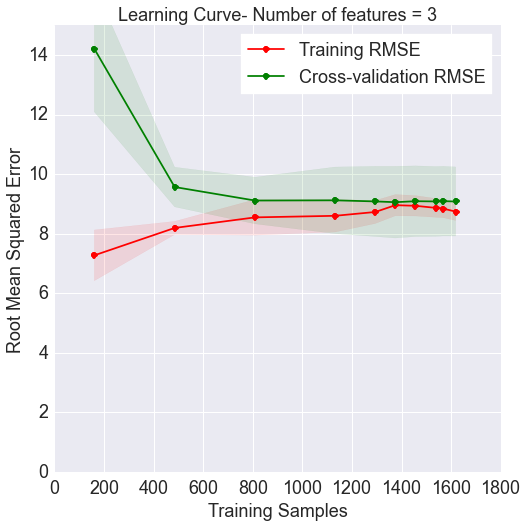

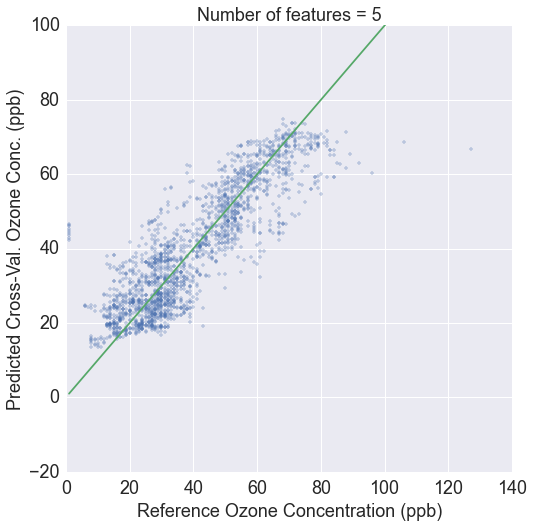

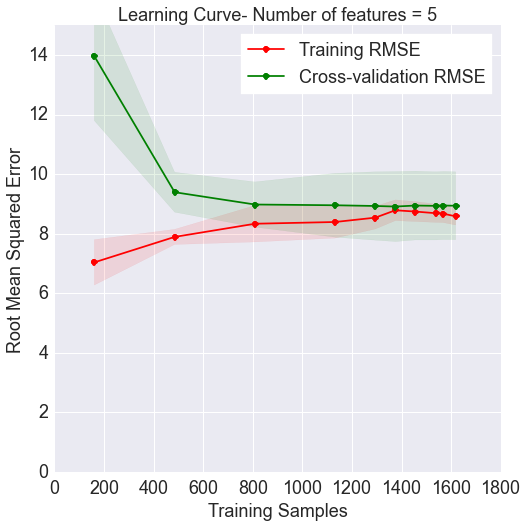

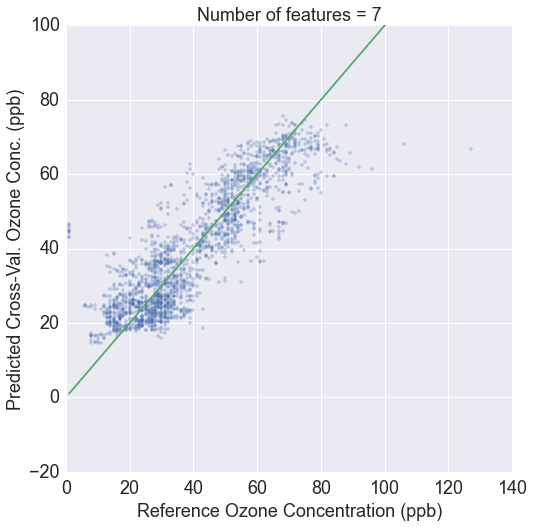

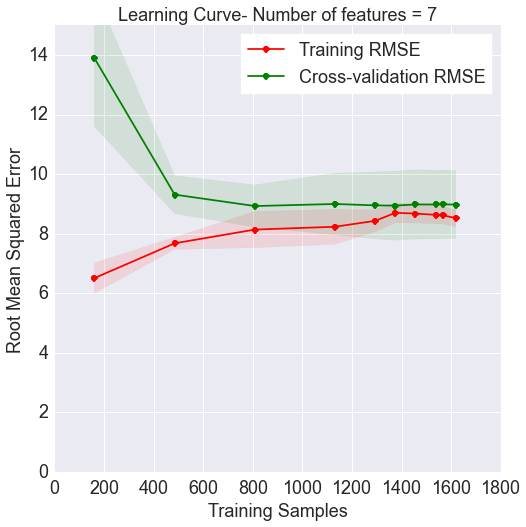

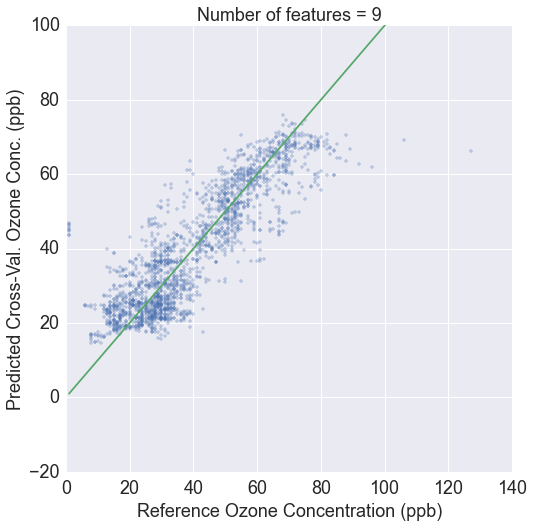

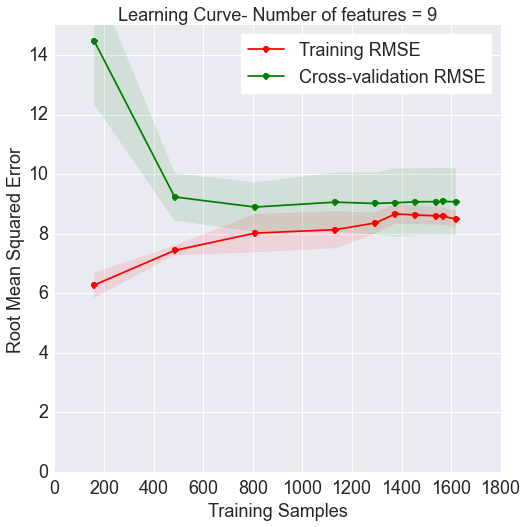

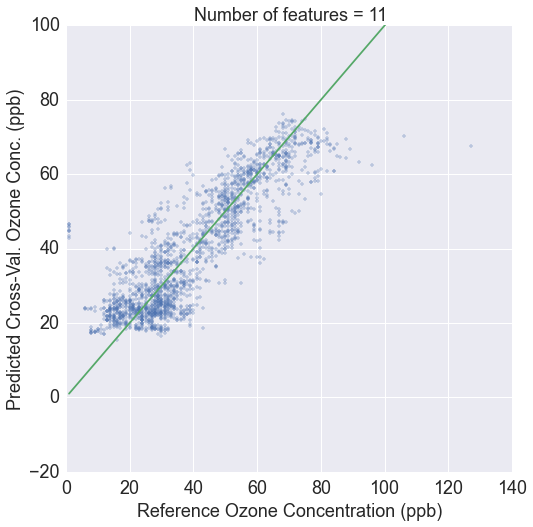

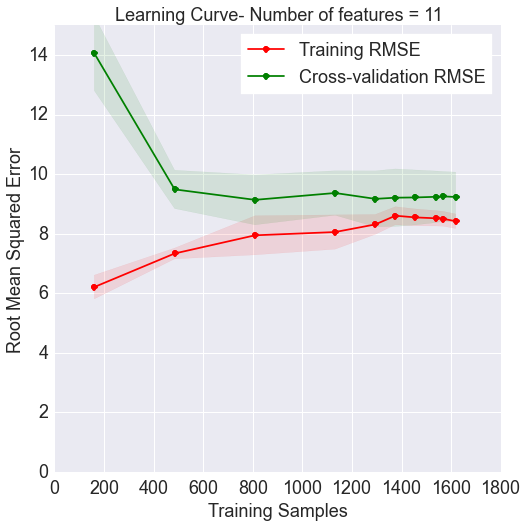

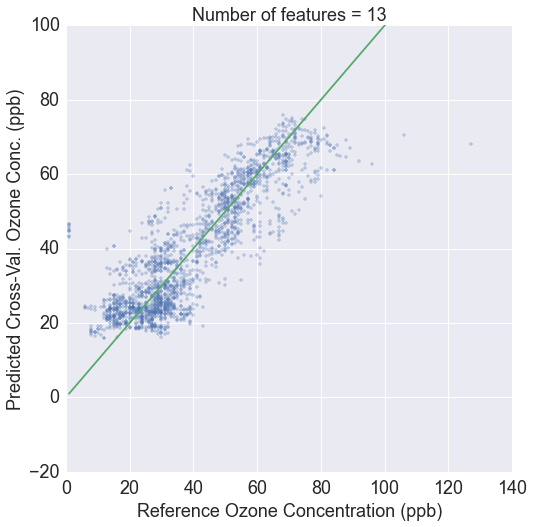

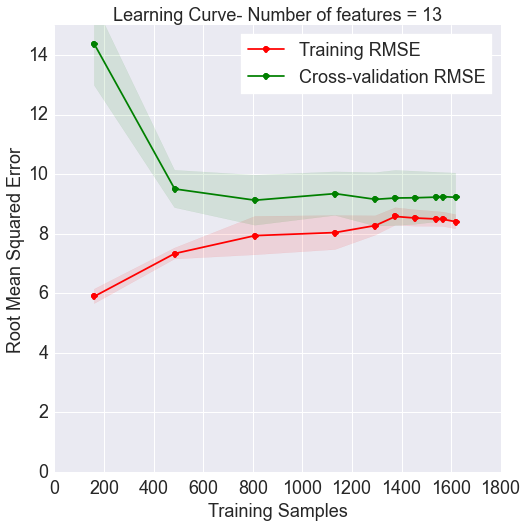

In [26]:
i = 1
while i < 15:
    num_good_feat = i
    df_cv_1, df_H_1 = find_fitted_cv_values_for_best_features(df_tr, df_hold, fs_features, num_good_feat, linear_model.LinearRegression(), chunks_tr, ref_column)
    fitted_vs_ref_plot(df_cv_1, i, ref_column) 
    plot_learning_curve(lin_regr, "Learning Curve- Number of features = " + str(i), df_tr[fs_features[:i]].values, df_tr[ref_column].values, (0,15), 5, np.array([0.1, 0.3, 0.5, 0.7, 0.8, 0.85, 0.9, 0.95,0.97, 1.0]))
    i += 2

In [19]:
fs_features = ['ln_O3_int_lag_5', 'rh_cu', 'ln_rh_int_lag_3', 'e2v03_slope_lag_5', 'Temp_slope_lag_3', 'Temp_slope_lag_4', 'rh_sq', 'ln_rh_int_lead_2', 'ln_temp_slope_lead_2', 'ln_temp', '03_mult_rh_&_temp', 'Rh_slope_lead_5', 'e2v03_int_lag_1', 'e2v03_int_lead_1', 'e2v03_slope_lag_1']

#### Enter the chosen number of features, and perform a linear regression.

In [20]:
num_good_feat = 8
best_features = fs_features[:num_good_feat]
MSE_CV, MSE_T, MSE_H, high_MSE_cv, X_pred_cv_best, y_cv_best, df_cv_lin_best, df_H_lin_best = cross_validation_by_day(lin_regr, best_features, df_tr, df_hold, days_tr, ref_column, cutoff_value)

Training RMSE: 8.1
Cross-Validation RMSE: 8.0 , High-Value CV RMSE: 9.0 , CV High Diff. in Mean (>50): -3.0
Holdout RMSE: 14.0 , High-Value Holdout RMSE: 9.0 , Holdout High Diff. in Mean.: -7.9


#### Print Best Features

In [21]:
best_features

['ln_O3_int_lag_5',
 'rh_cu',
 'ln_rh_int_lag_3',
 'e2v03_slope_lag_5',
 'Temp_slope_lag_3',
 'Temp_slope_lag_4',
 'rh_sq',
 'ln_rh_int_lead_2']

### Plot the cross-validation data and residuals below.

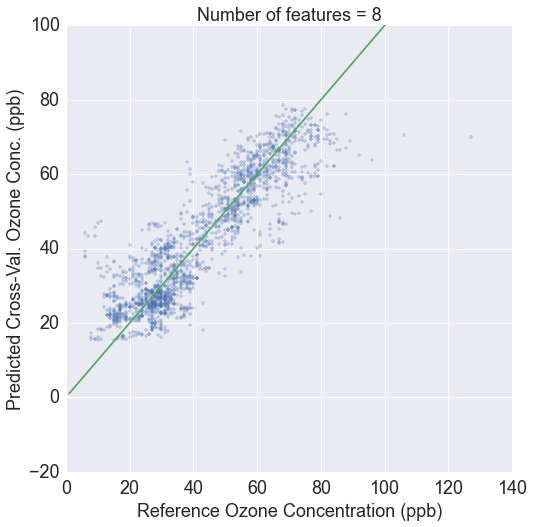

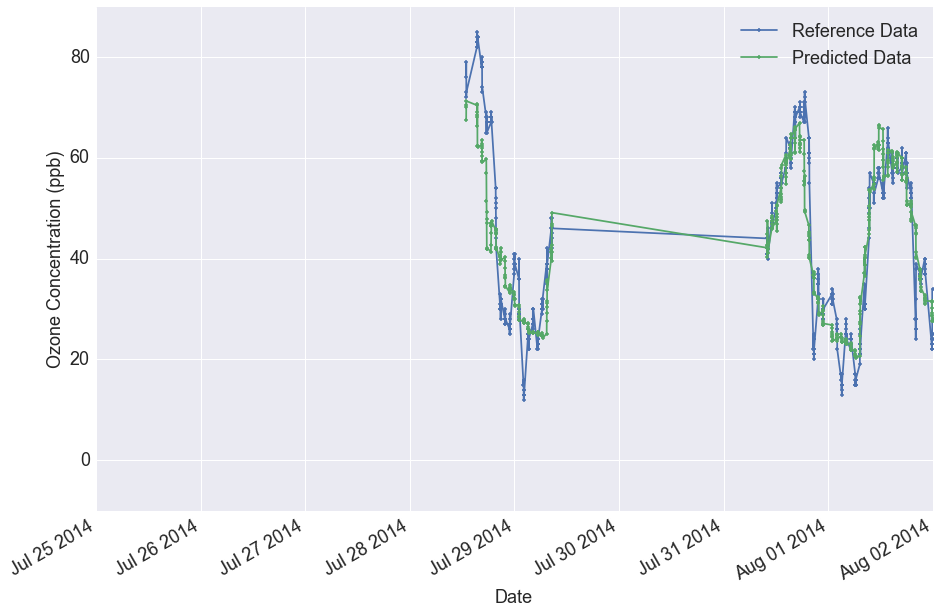

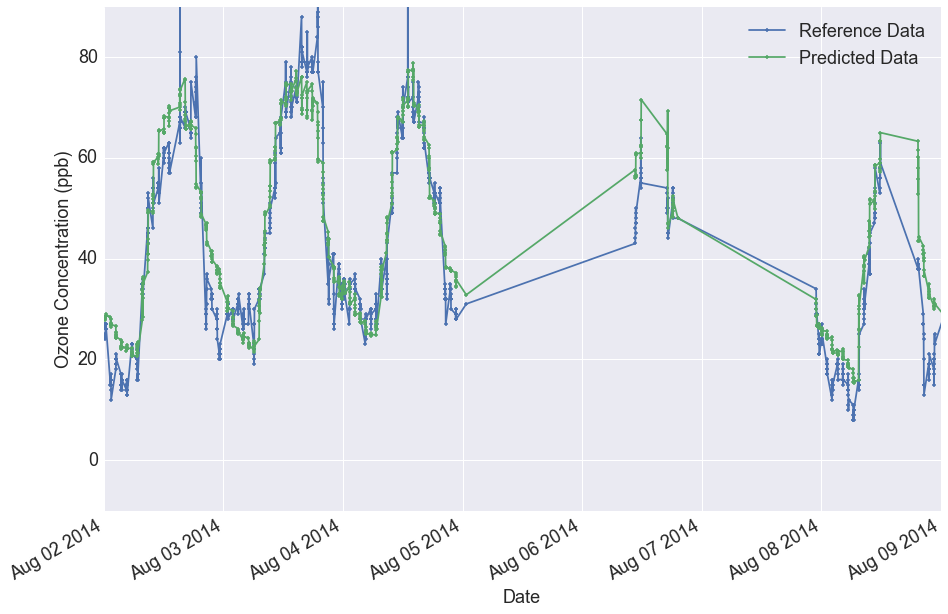

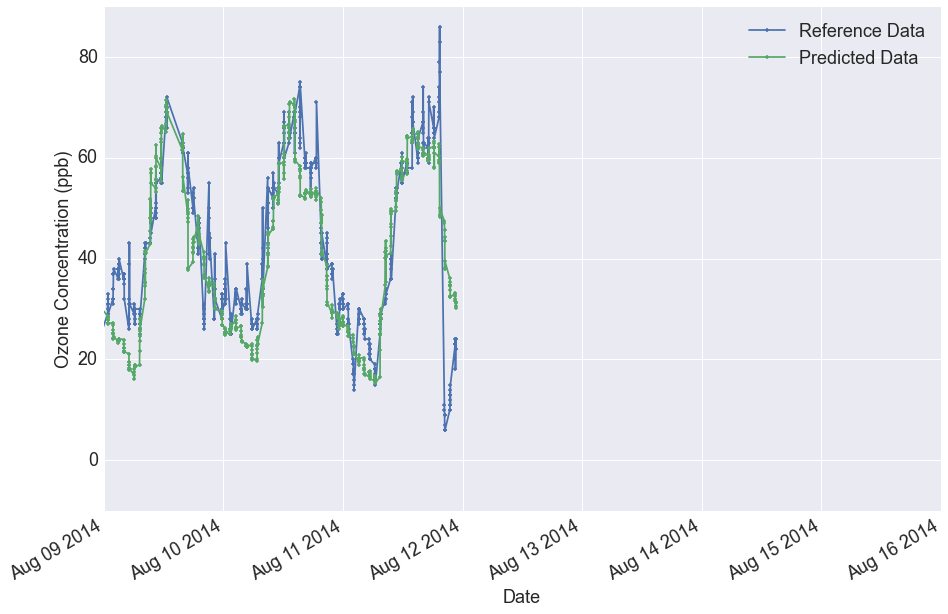

In [30]:
df_lin_regr_best_feat_cv, df_lin_regr_best_feat_H  = find_fitted_cv_values_for_best_features(df_tr, df_hold, fs_features, num_good_feat, linear_model.LinearRegression(), chunks_tr, ref_column)
fitted_vs_ref_plot(df_lin_regr_best_feat_cv, num_good_feat, ref_column)
plot_fitted_and_ref_vs_time(df_lin_regr_best_feat_cv, pod_number, 1, ref_column)
plot_fitted_and_ref_vs_time(df_lin_regr_best_feat_cv, pod_number, 2, ref_column)
plot_fitted_and_ref_vs_time(df_lin_regr_best_feat_cv, pod_number, 3, ref_column)

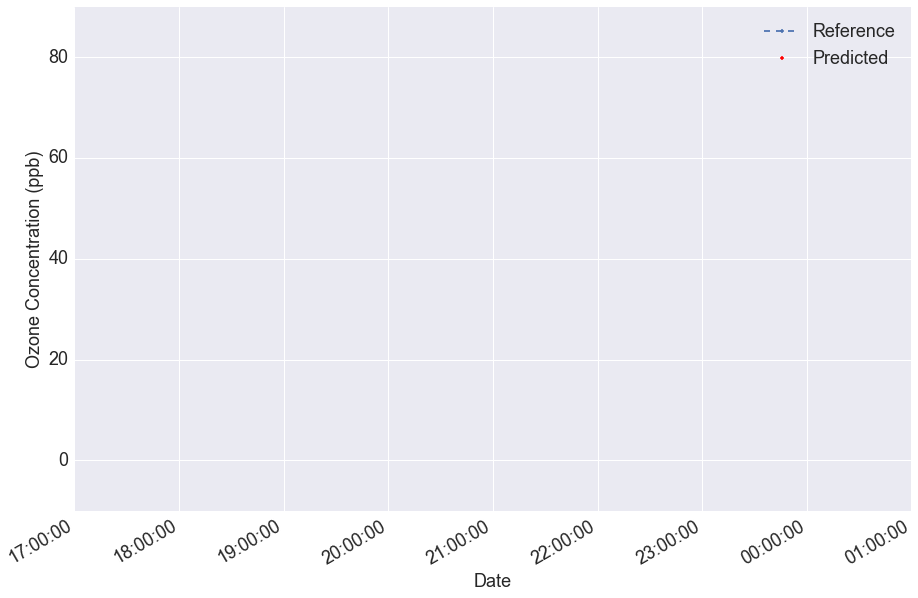

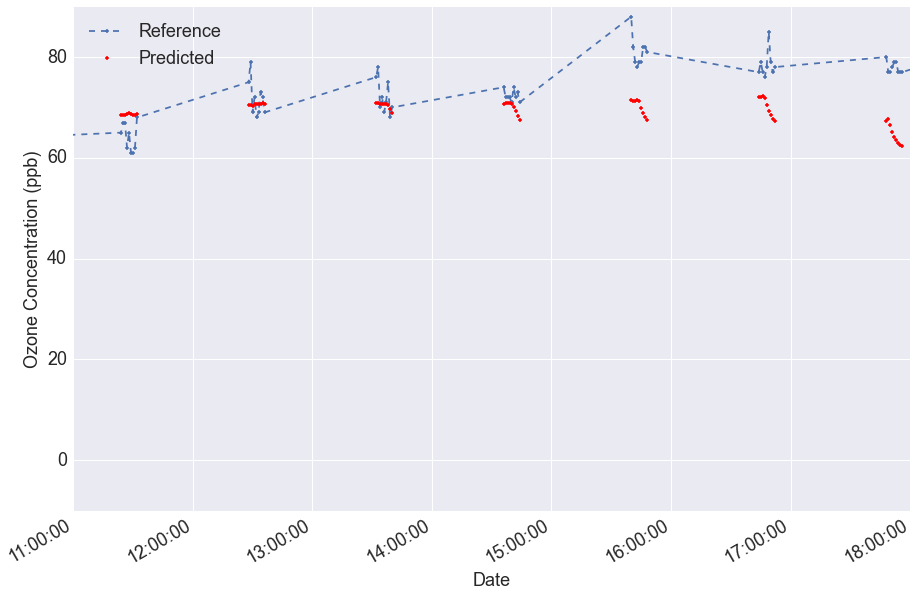

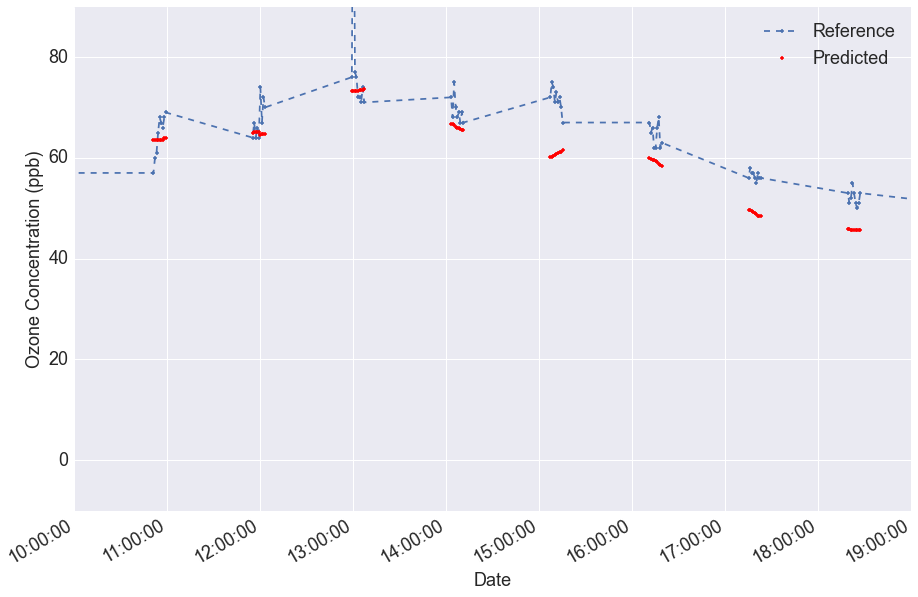

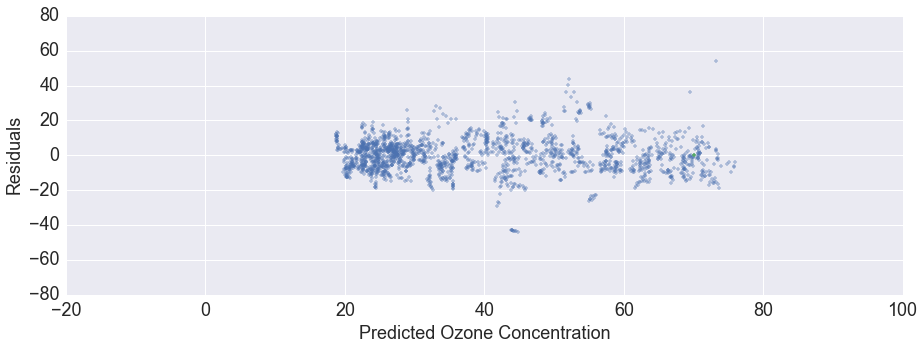

In [95]:
plot_fitted_and_ref_vs_time_no_lines(df_lin_regr_best_feat_cv, pod_number, 4, ref_column)
plot_fitted_and_ref_vs_time_no_lines(df_lin_regr_best_feat_cv, pod_number, 5, ref_column)
plot_fitted_and_ref_vs_time_no_lines(df_lin_regr_best_feat_cv, pod_number, 6, ref_column)
resid = plot_resid_vs_conc(df_lin_regr_best_feat_cv, ref_column)

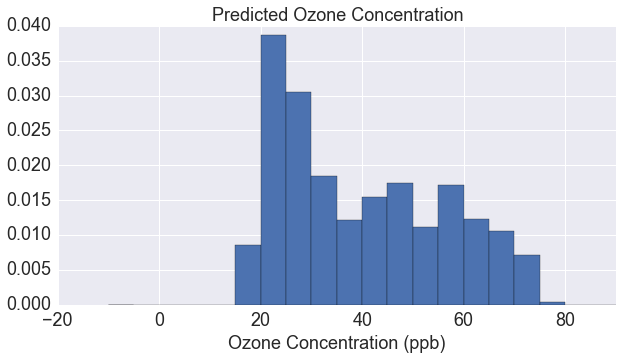

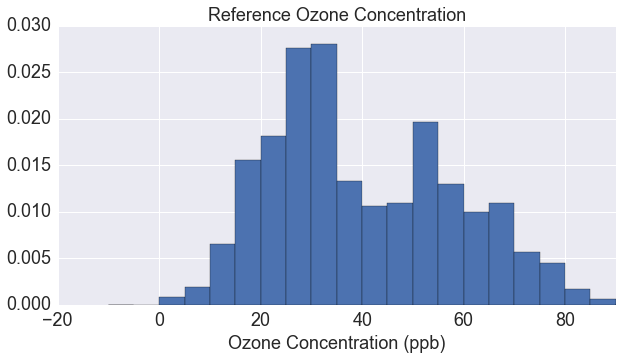

In [96]:
plot_hist(X_pred_cv_best, y_cv_best, 'Predicted Ozone Concentration')
plot_hist(y_cv_best, X_pred_cv_best, 'Reference Ozone Concentration')

In [24]:
X = df_scaled[best_features].values
y = df_scaled[ref_column].values
lin_regr.fit(X, y)
pred = cross_val_predict(lin_regr, X, y)
df_pred = pd.DataFrame({'pred':pred}, index=df_scaled.index)

In [25]:
def find_avg_close(df):
    start_time = []
    closed_avg = []
    flux = []
    count = 0
    for row in range(1,len(df)):
        if (df.index[row] - df.index[row-1]) > pd.Timedelta(minutes=3):
            start_time.append(df.index[row])
            closed_avg.append(round(df.pred[row:row+3].median(), 1))
            count += 1
    return closed_avg, start_time

In [26]:
open_avg, start_time = find_avg_close(df_pred)

In [27]:
df_flux = pd.DataFrame(open_avg, index = start_time, columns = ['Open Conc.'])
df_flux.head()

Open Conc.
2014-07-28 15:24:00        67.4
2014-07-28 16:28:00        60.2
2014-07-28 17:32:00        56.2
2014-07-28 18:36:00        43.1
2014-07-28 19:40:00        45.1

In [32]:
df_flux.to_csv("open_conc.csv")

In [31]:
df_lin_regr_best_feat_cv.to_csv('data/open_plot.csv')

## Ridge Regression- All Features

In [32]:
fs_features = all_features
num_good_feat_ridge = len(all_features)

In [33]:
#define the training data
df_fits = df_tr[fs_features[:num_good_feat_ridge] + [ref_column] + ['day']].dropna()
X = df_scaled[fs_features[:num_good_feat_ridge]].values
y = df_scaled[ref_column].values

###Find the best lambda value using cross-validation

In [34]:
best_lambda_ridge, lambda_ridge, coefs, mean_score_lambda = find_best_lambda(Ridge, fs_features[:num_good_feat_ridge], df_fits, ref_column, 'custom_mse_scoring_function', days_tr, X, y, 0.0000001, 1000000, 3, cust_mse_fact, cutoff_value)

lambda: 1e-07
score: 9.83
lambda: 3e-07
score: 9.73
lambda: 9e-07
score: 9.68
lambda: 2.7e-06
score: 9.69
lambda: 8.1e-06
score: 9.7
lambda: 2.43e-05
score: 9.71
lambda: 7.29e-05
score: 9.73
lambda: 0.0002187
score: 9.79
lambda: 0.0006561
score: 9.9
lambda: 0.0019683
score: 9.96
lambda: 0.0059049
score: 9.96
lambda: 0.0177147
score: 9.91
lambda: 0.0531441
score: 9.86
lambda: 0.1594323
score: 9.8
lambda: 0.4782969
score: 9.72
lambda: 1.4348907
score: 9.65
lambda: 4.3046721
score: 9.57
lambda: 12.9140163
score: 9.51
lambda: 38.7420489
score: 9.48
lambda: 116.2261467
score: 9.49
lambda: 348.6784401
score: 9.56
lambda: 1046.0353203
score: 9.64
lambda: 3138.1059609
score: 9.74
lambda: 9414.3178827
score: 9.89
lambda: 28242.9536481
score: 10.4
lambda: 84728.8609443
score: 12.53
lambda: 254186.582833
score: 16.46
lambda: 762559.748499
score: 19.6
Best Lambda: 38.7420489


###Plot the values of lambda versus the coefficients and the custom score. 

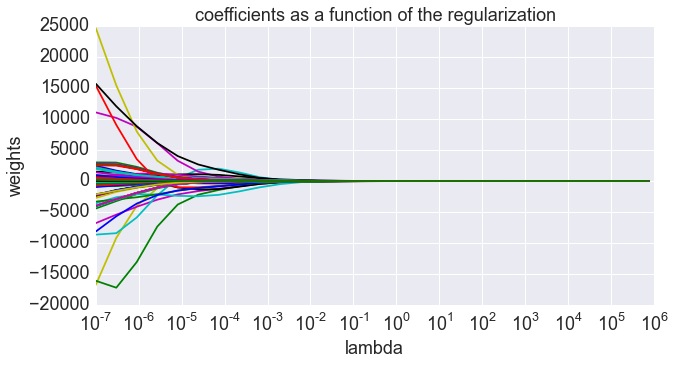

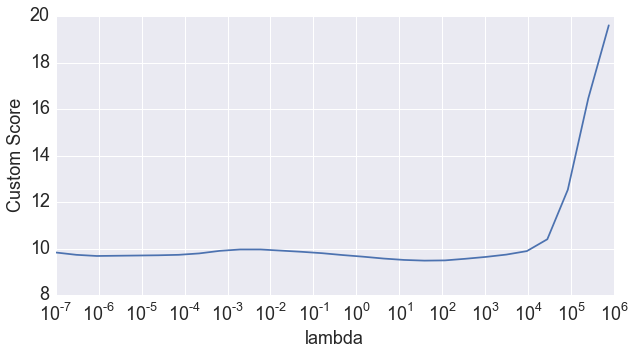

In [35]:
plot_lambda(lambda_ridge, coefs, mean_score_lambda)

####Use the best lambda value found above to find errors.

In [36]:
MSE_CV_ridge, MSE_T_ridge, MSE_H_ridge, high_MSE_cv_ridge, X_pred_cv_ridge, y_cv_ridge, df_cv_ridge, df_H_ridge = cross_validation_by_day(Ridge(alpha = best_lambda_ridge), all_features, df_tr, df_hold, days_tr, ref_column, cutoff_value)

Training RMSE: 8.1
Cross-Validation RMSE: 9.0 , High-Value CV RMSE: 10.0 , CV High Diff. in Mean (>50): -3.3
Holdout RMSE: 5.0 , High-Value Holdout RMSE: 5.0 , Holdout High Diff. in Mean.: -4.7


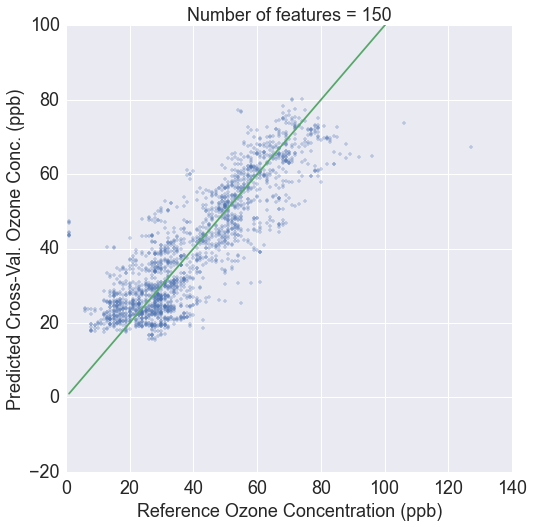

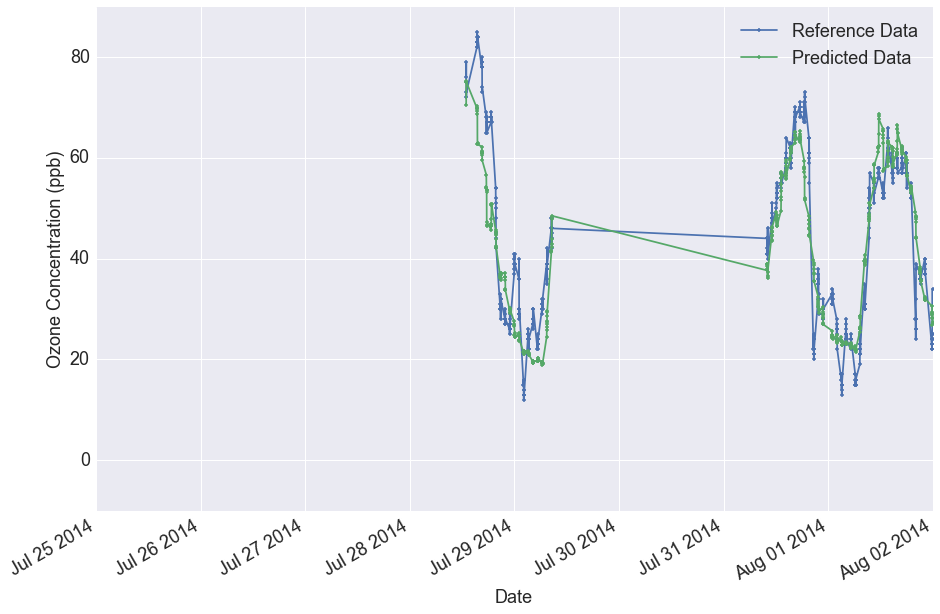

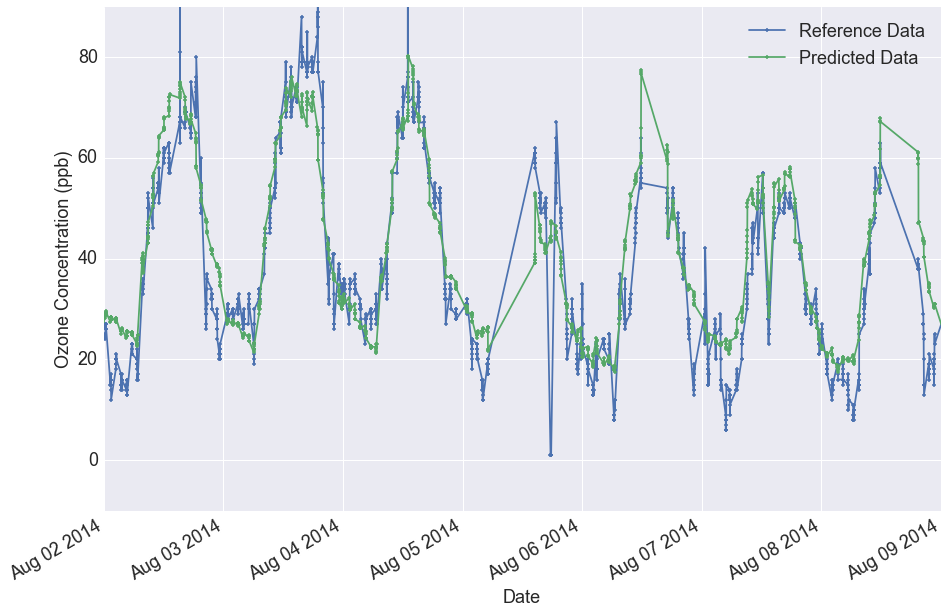

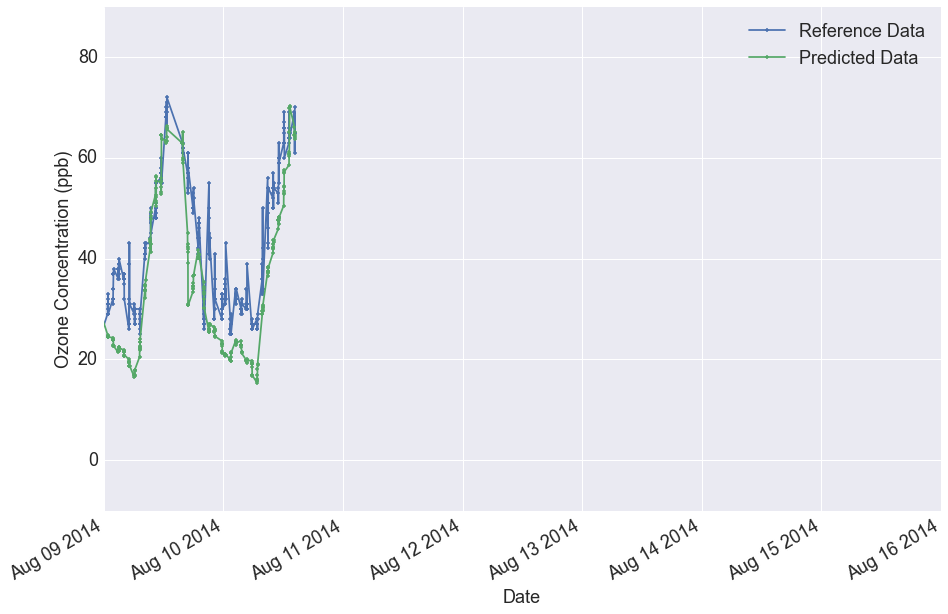

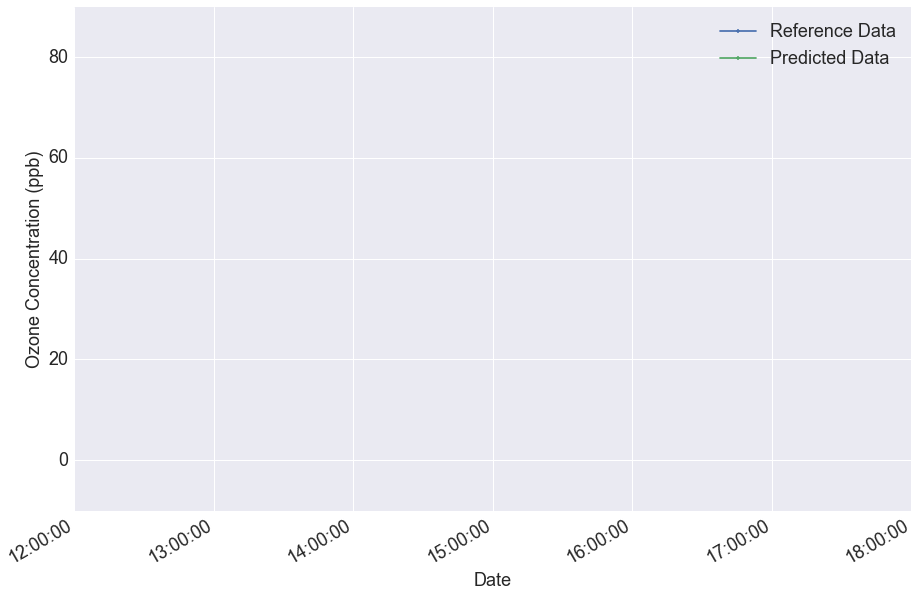

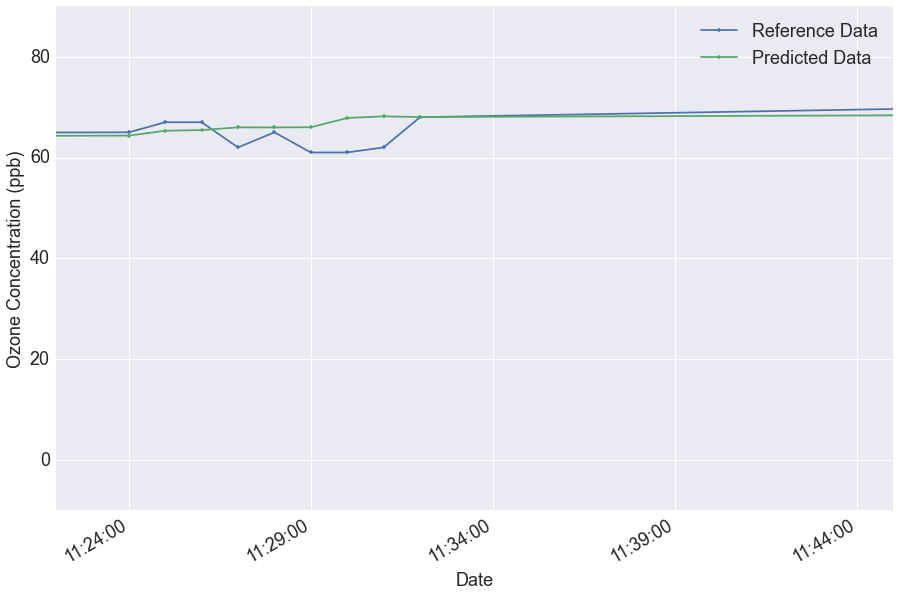

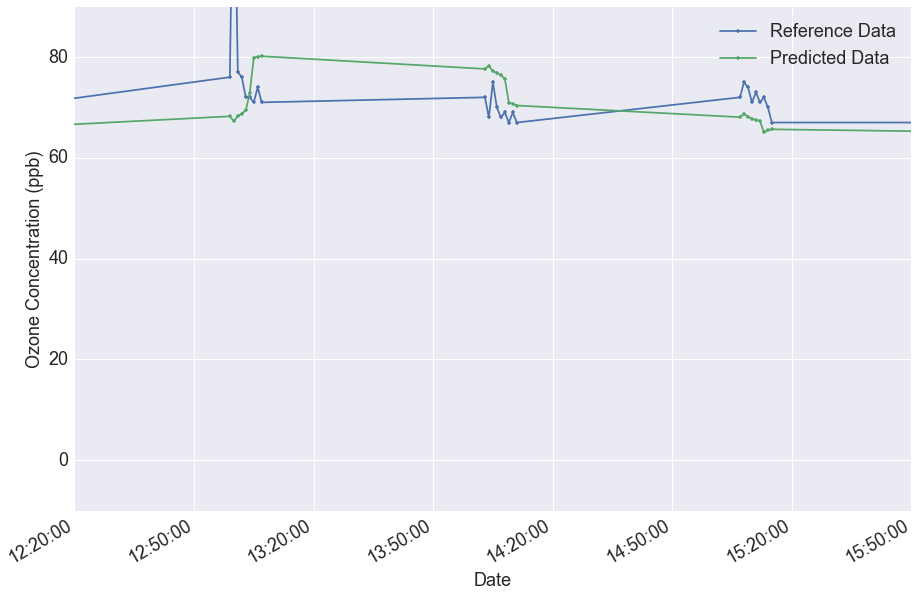

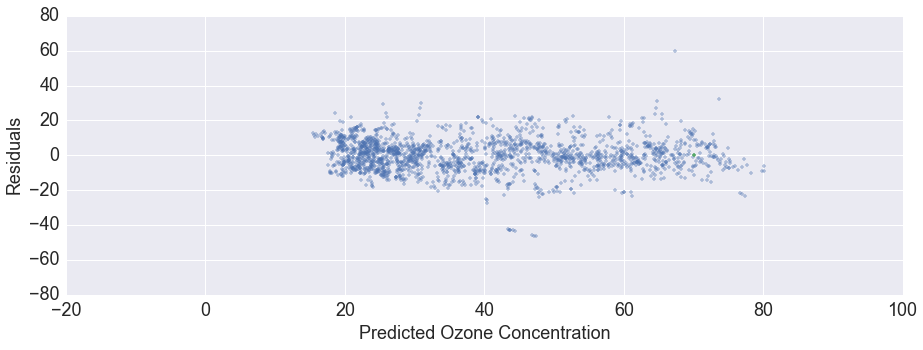

In [37]:
fitted_vs_ref_plot(df_cv_ridge, num_good_feat_ridge, ref_column)
plot_fitted_and_ref_vs_time(df_cv_ridge, pod_number, 1, ref_column)
plot_fitted_and_ref_vs_time(df_cv_ridge, pod_number, 2, ref_column)
plot_fitted_and_ref_vs_time(df_cv_ridge, pod_number, 3, ref_column)
plot_fitted_and_ref_vs_time(df_cv_ridge, pod_number, 4, ref_column)
plot_fitted_and_ref_vs_time(df_cv_ridge, pod_number, 5, ref_column)
plot_fitted_and_ref_vs_time(df_cv_ridge, pod_number, 6, ref_column)
resid = plot_resid_vs_conc(df_cv_ridge, ref_column)

## Lasso- Best Features

In [67]:
best_lambda_lasso_best, lambda_lasso_best, coefs_lasso_best, mean_score_lambda_lasso_best = find_best_lambda(Lasso, best_features, df_fits_best, ref_column, 'custom_mse_scoring_function', days_tr, X, y, 0.0000000000001, 100, 3, cust_mse_fact, cutoff_value)

lambda: 1e-13


KeyError: "['e2v03' 'no2' 'Temp' 'Rh' 'days from start' 'O3_sqrt' 'O3_sq' 'O3_cu'] not in index"

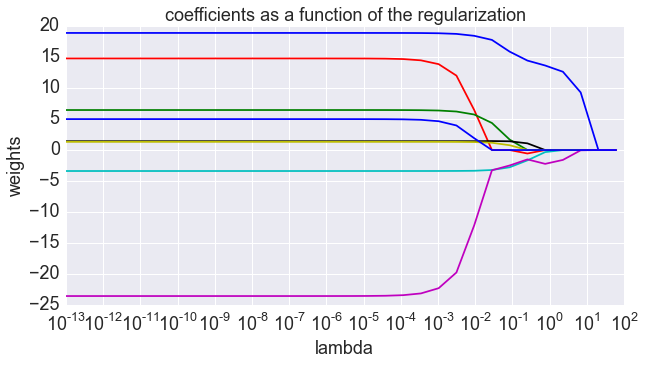

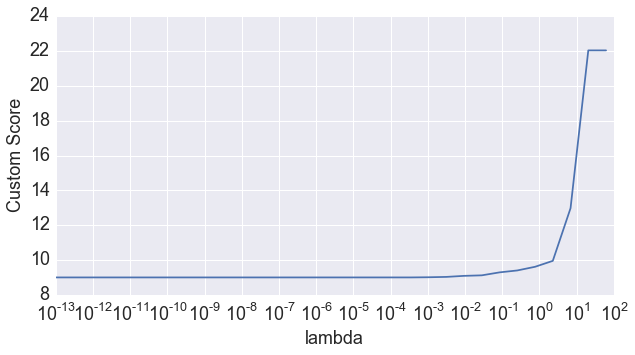

In [48]:
plot_lambda(lambda_lasso_best, coefs_lasso_best, mean_score_lambda_lasso_best)

In [49]:
MSE_CV_lasso_best, MSE_T_lasso_best, MSE_H_lasso_best, high_MSE_cv_lasso_best, X_pred_cv_lasso_best, y_cv_lasso, df_cv_lasso_best, df_H_lasso_best = cross_validation_by_day(Lasso(alpha = best_lambda_lasso), best_features, df_tr, df_hold, days_tr, ref_column, cutoff_value)

Training RMSE: 8.6
Cross-Validation RMSE: 9.0 , High-Value CV RMSE: 9.0 , CV High Diff. in Mean (>50): -3.7
Holdout RMSE: 6.0 , High-Value Holdout RMSE: 2.0 , Holdout High Diff. in Mean.: 0.8


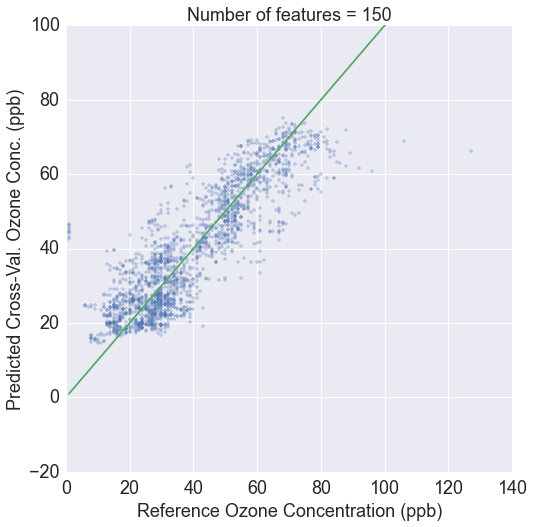

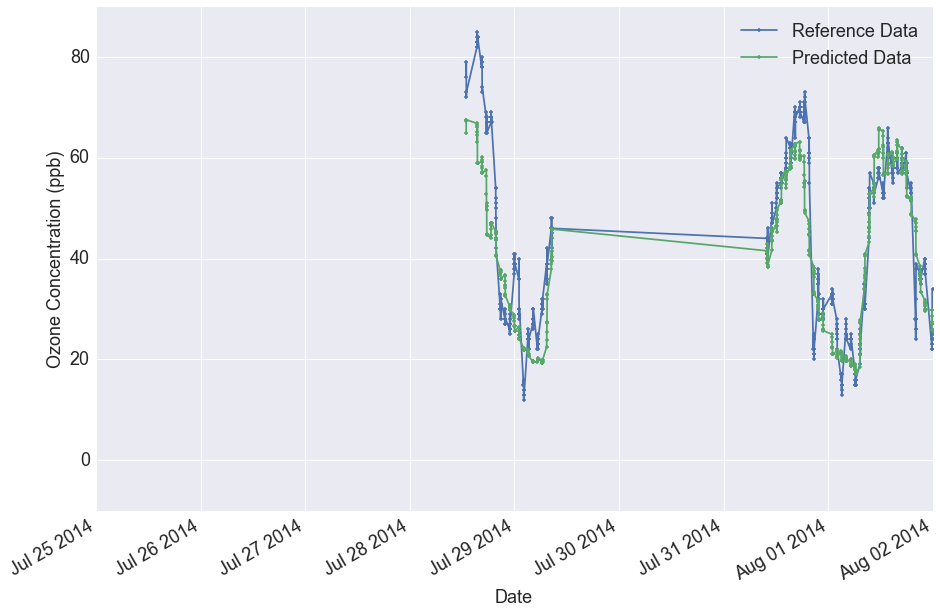

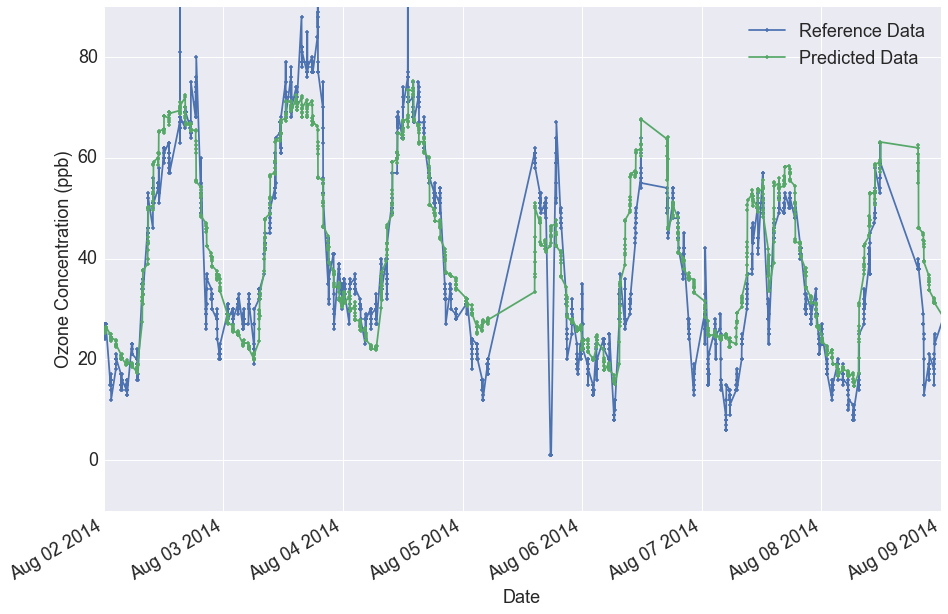

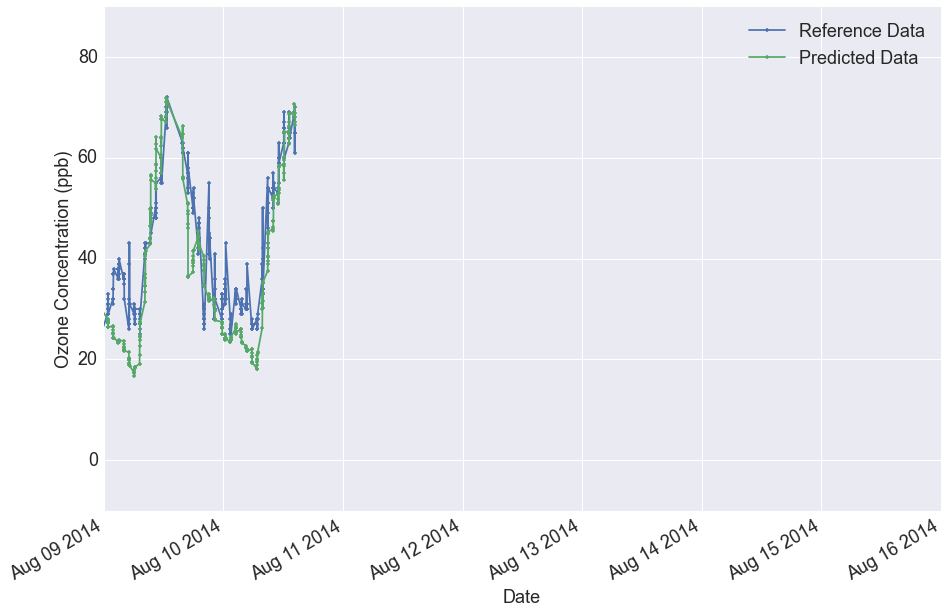

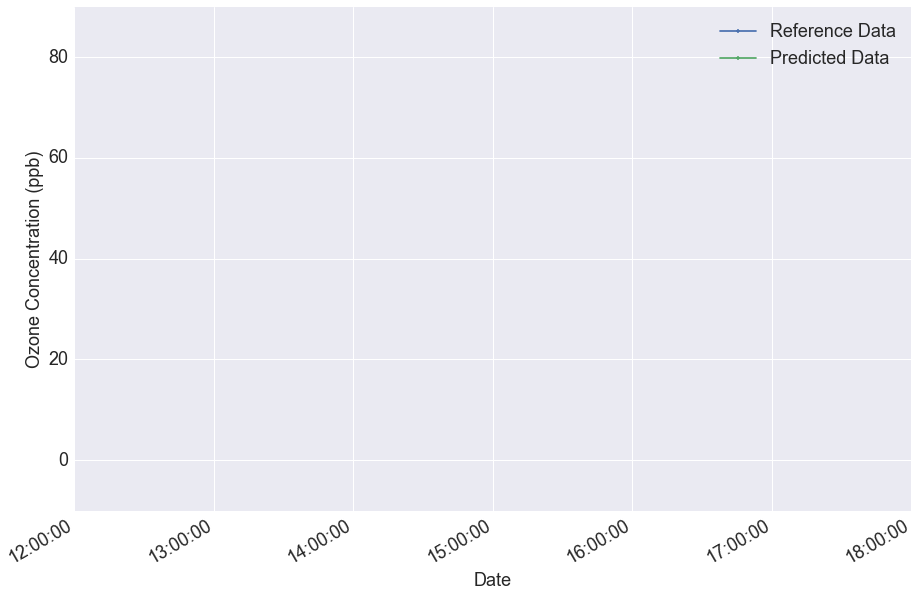

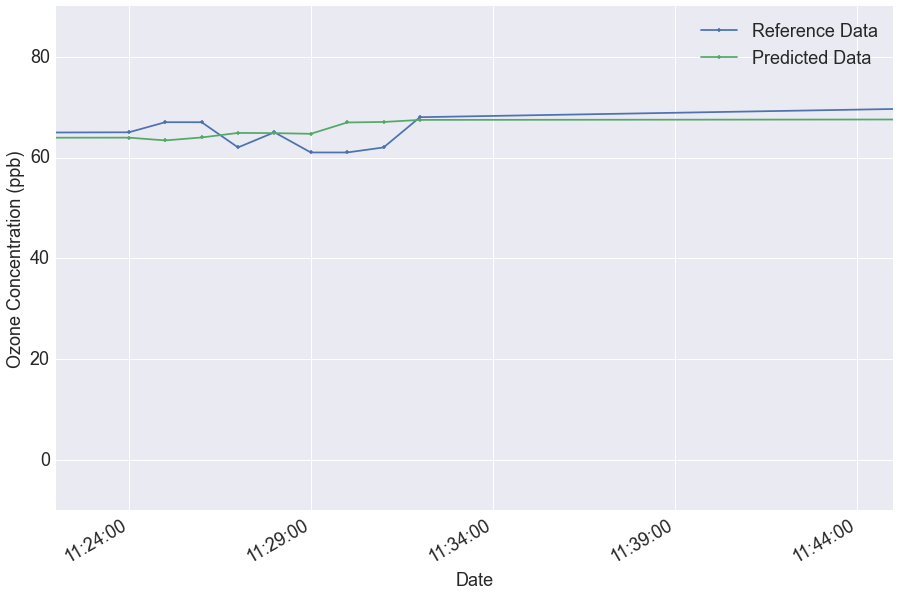

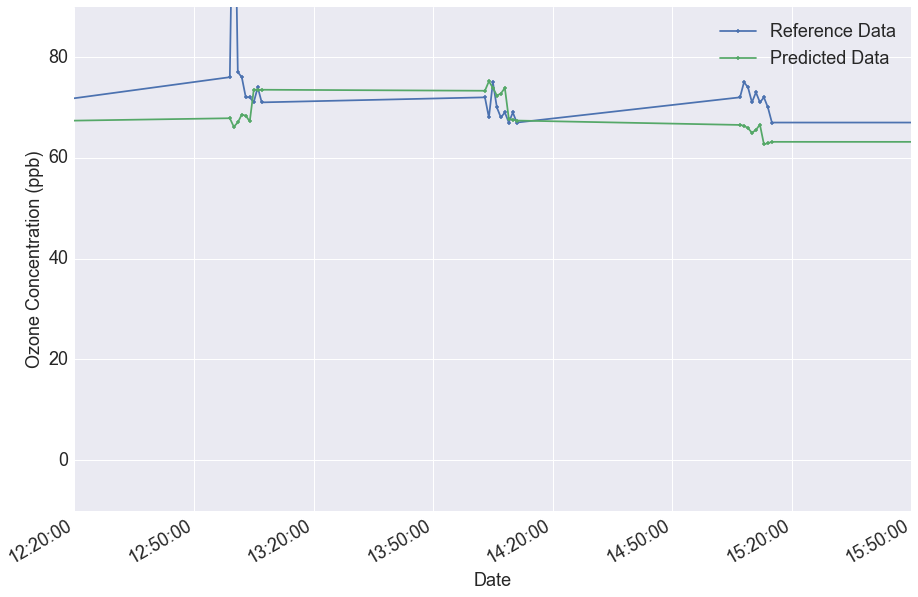

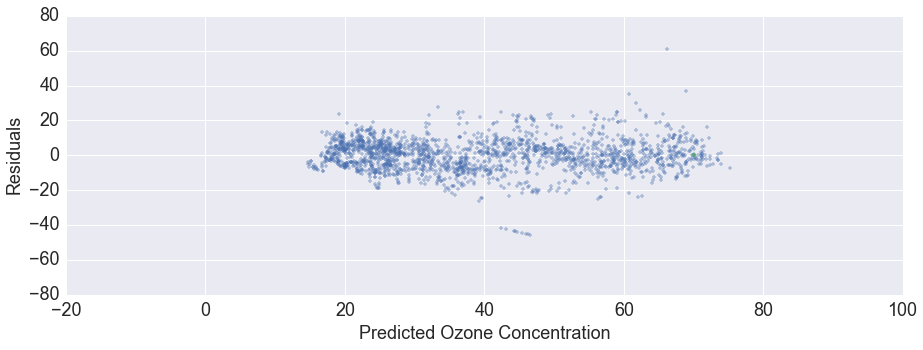

In [50]:
fitted_vs_ref_plot(df_cv_lasso_best, num_good_feat_ridge, ref_column)
plot_fitted_and_ref_vs_time(df_cv_lasso_best, pod_number, 1, ref_column)
plot_fitted_and_ref_vs_time(df_cv_lasso_best, pod_number, 2, ref_column)
plot_fitted_and_ref_vs_time(df_cv_lasso_best, pod_number, 3, ref_column)
plot_fitted_and_ref_vs_time(df_cv_lasso_best, pod_number, 4, ref_column)
plot_fitted_and_ref_vs_time(df_cv_lasso_best, pod_number, 5, ref_column)
plot_fitted_and_ref_vs_time(df_cv_lasso_best, pod_number, 6, ref_column)
resid = plot_resid_vs_conc(df_cv_lasso_best, ref_column)

#### Support Vector Machine- Best Features

In [51]:
RMSE_CV_day, df_svm_fit, df_H_svm = fit_svm_and_find_MSE(best_features, df_tr, days_tr, ref_column, cutoff_value, df_hold, cust_mse_fact)  

7-28
7-29
7-31
8-1
8-2
8-3
8-4
8-5
8-6
8-7
8-8
8-9
8-10
{'epsilon': 0.1, 'C': 1}
Training RMSE: 2.9
Cross-Validation RMSE: 3.0 , High-Value CV RMSE: 3.0 , CV High Diff. in Mean (>50): -3.9
Holdout RMSE: 6.0 , High-Value Holdout RMSE: 2.0 , Holdout High Diff. in Mean.: 0.6


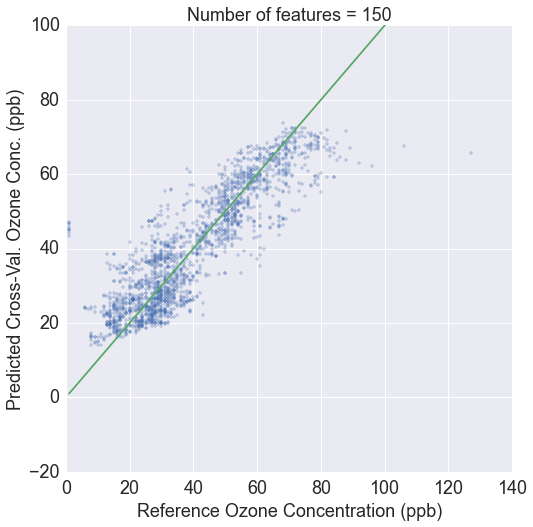

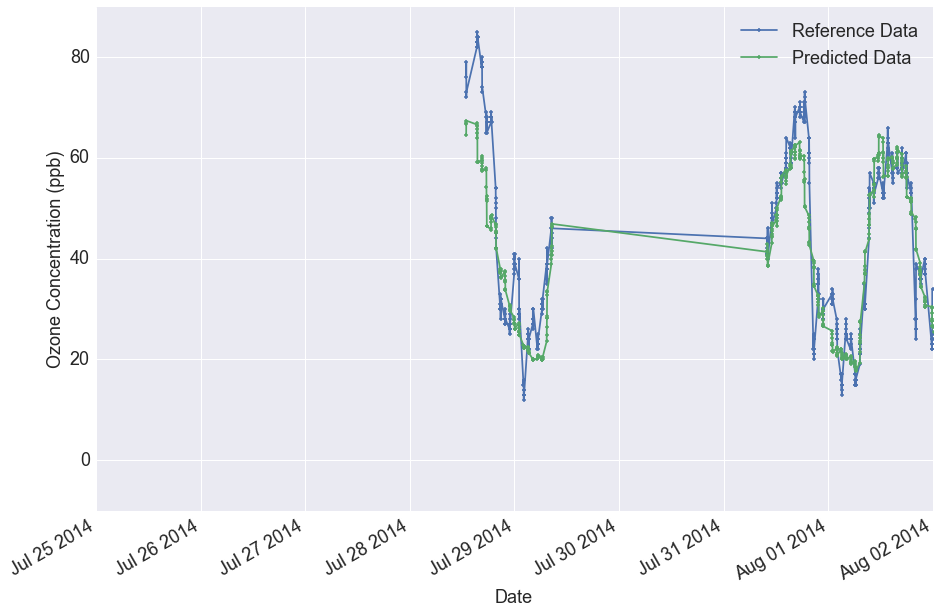

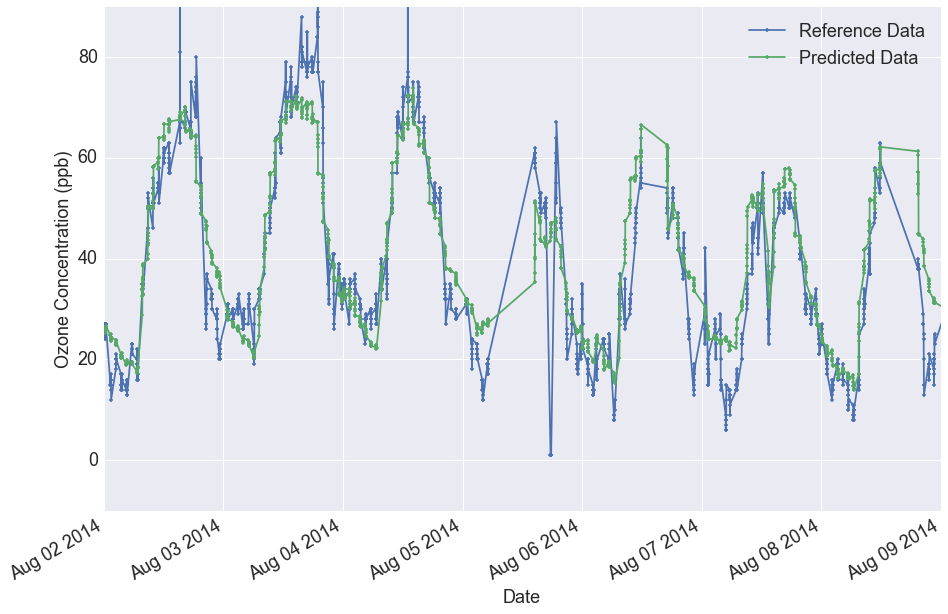

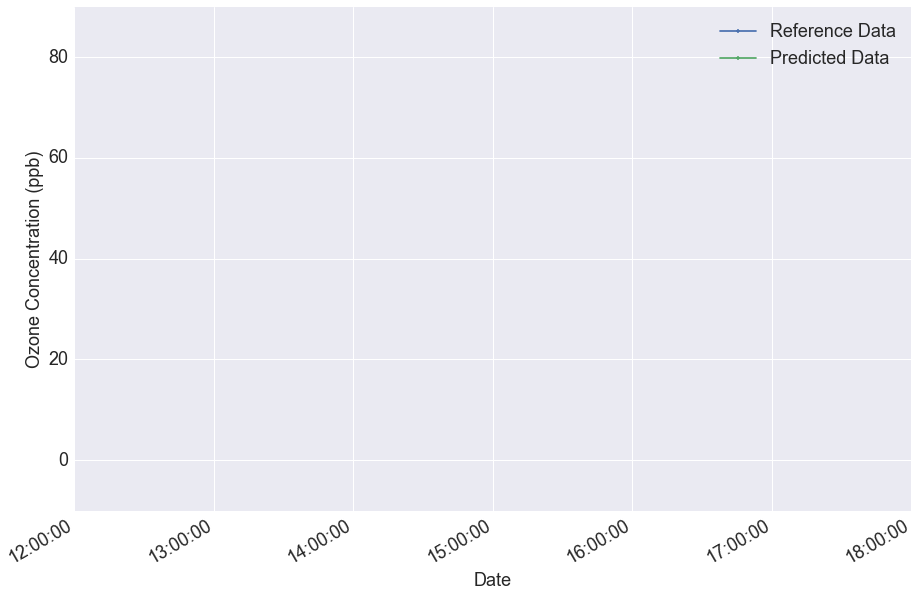

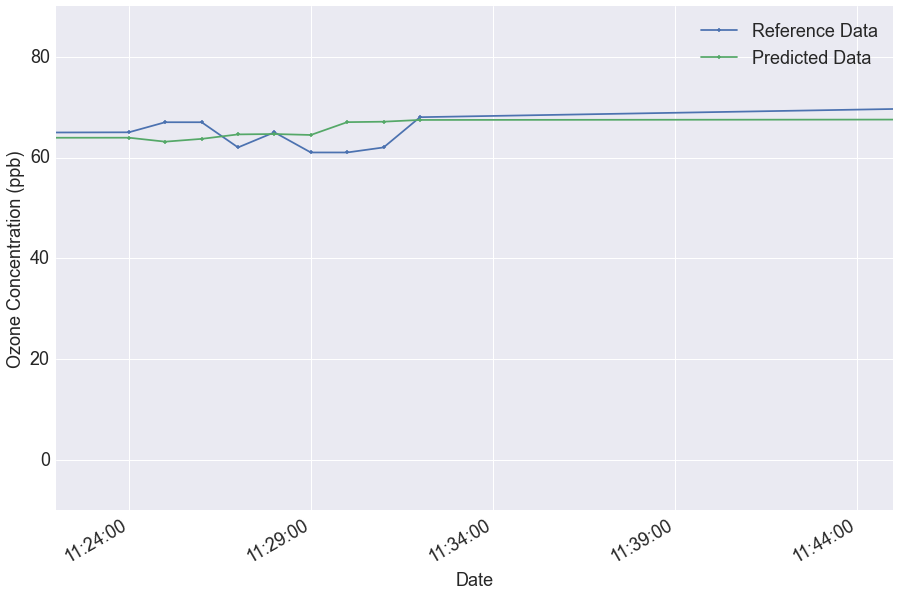

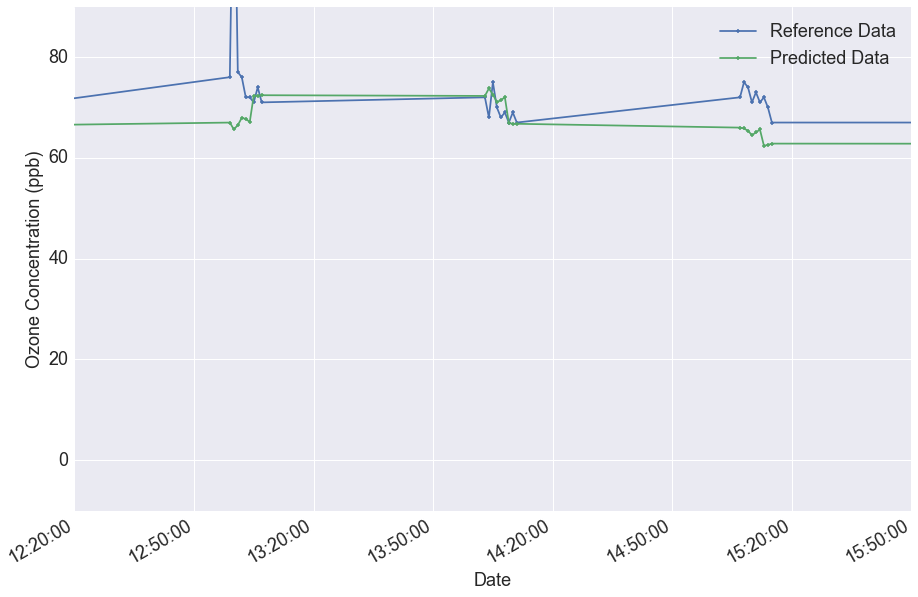

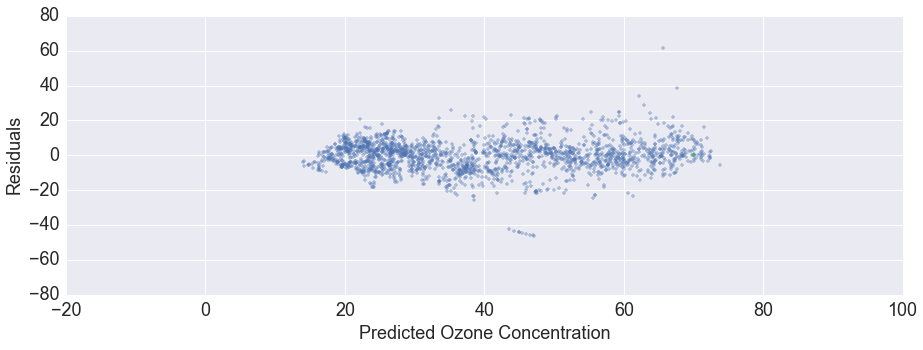

In [52]:
fitted_vs_ref_plot(df_svm_fit, num_good_feat_ridge, ref_column)
plot_fitted_and_ref_vs_time(df_svm_fit, pod_number, 1, ref_column)
plot_fitted_and_ref_vs_time(df_svm_fit, pod_number, 2, ref_column)
plot_fitted_and_ref_vs_time(df_svm_fit, pod_number, 4, ref_column)
plot_fitted_and_ref_vs_time(df_svm_fit, pod_number, 5, ref_column)
plot_fitted_and_ref_vs_time(df_svm_fit, pod_number, 6, ref_column)
resid = plot_resid_vs_conc(df_svm_fit, ref_column)

#Support Vector Machine- All Features

In [53]:
RMSE_CV_day_all, df_svm_fit_all, df_H_svm_all = fit_svm_and_find_MSE(all_features, df_tr, days_tr, ref_column, cutoff_value, df_hold, cust_mse_fact)  

7-28
7-29
7-31
8-1
8-2
8-3
8-4
8-5
8-6
8-7
8-8
8-9
8-10
{'epsilon': 0.1, 'C': 1}
Training RMSE: 2.9
Cross-Validation RMSE: 3.0 , High-Value CV RMSE: 3.0 , CV High Diff. in Mean (>50): -3.4
Holdout RMSE: 5.0 , High-Value Holdout RMSE: 7.0 , Holdout High Diff. in Mean.: -6.5


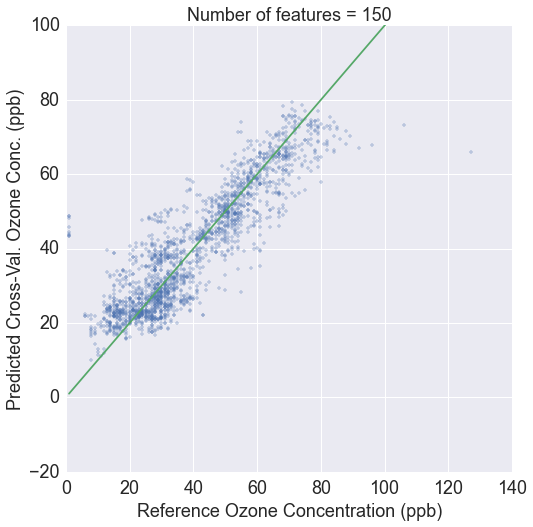

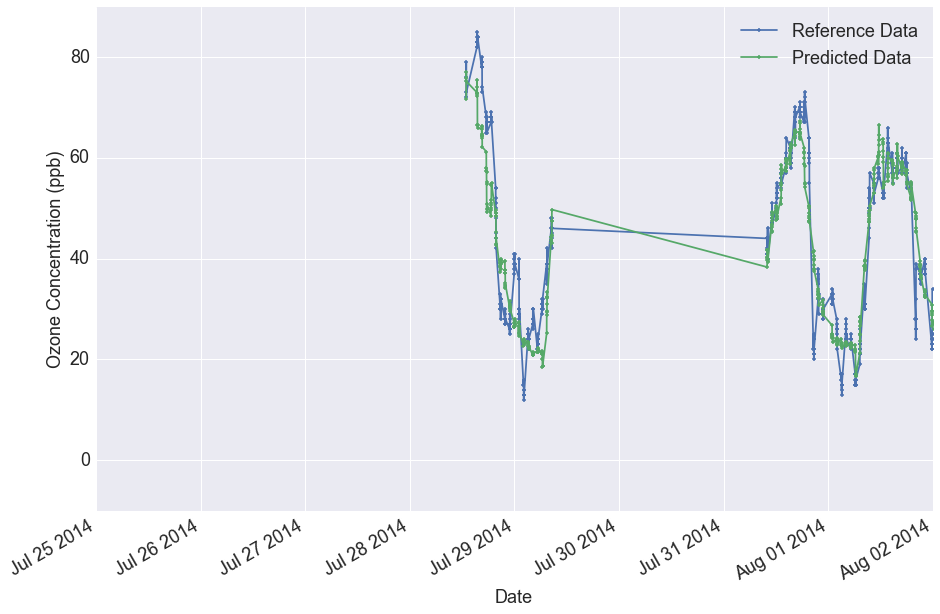

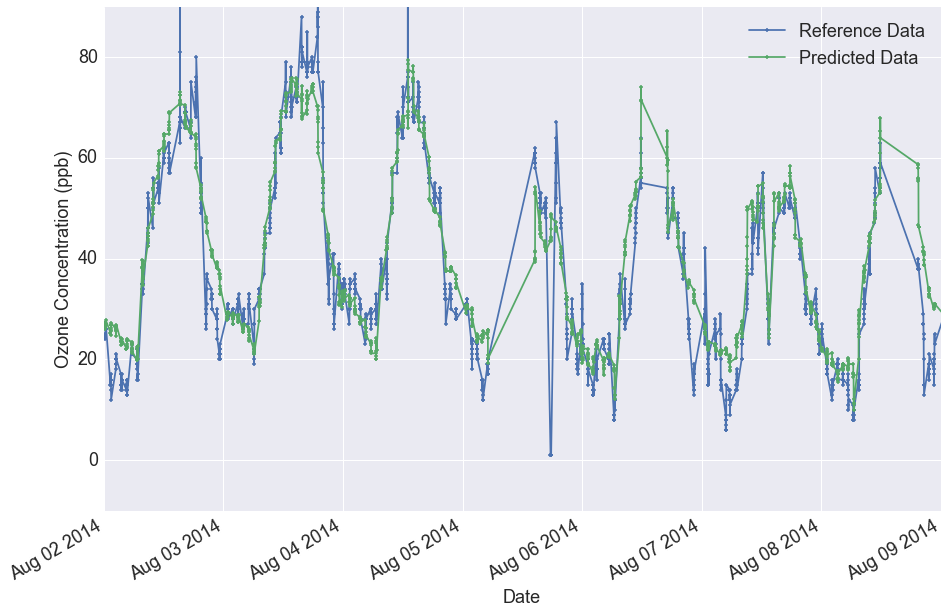

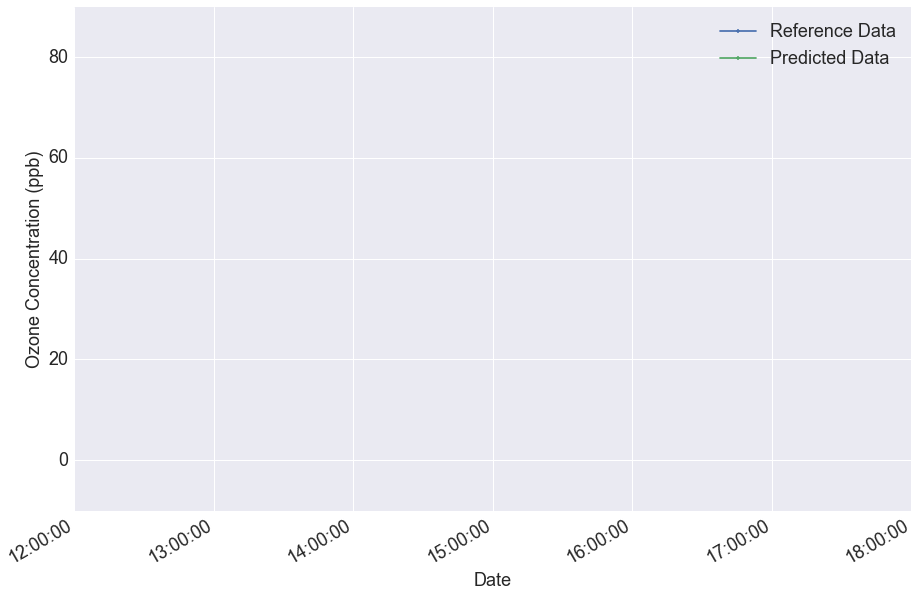

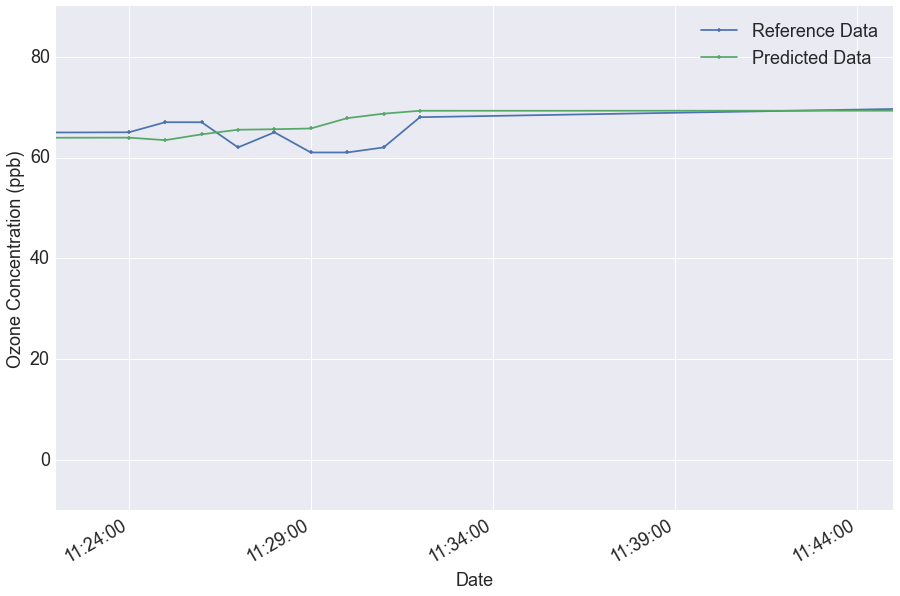

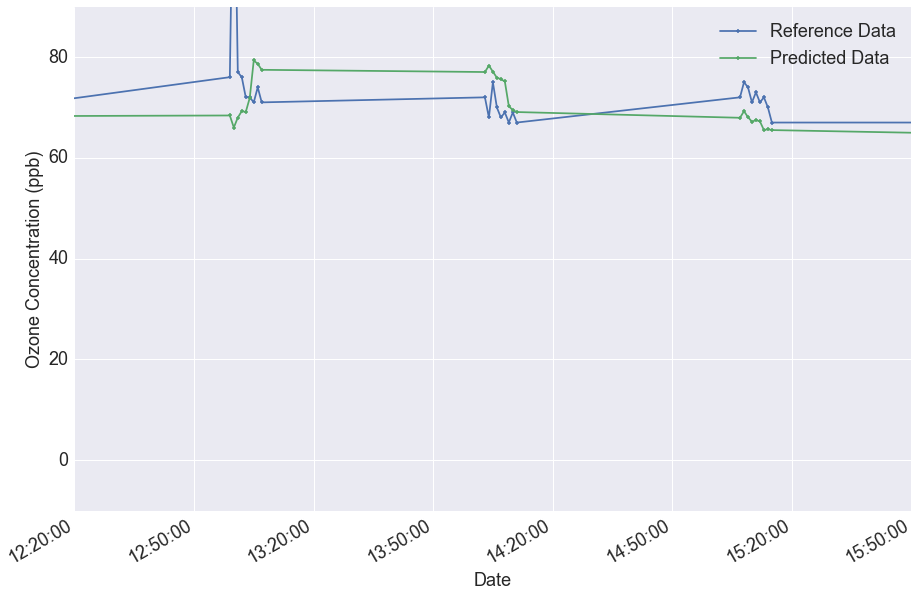

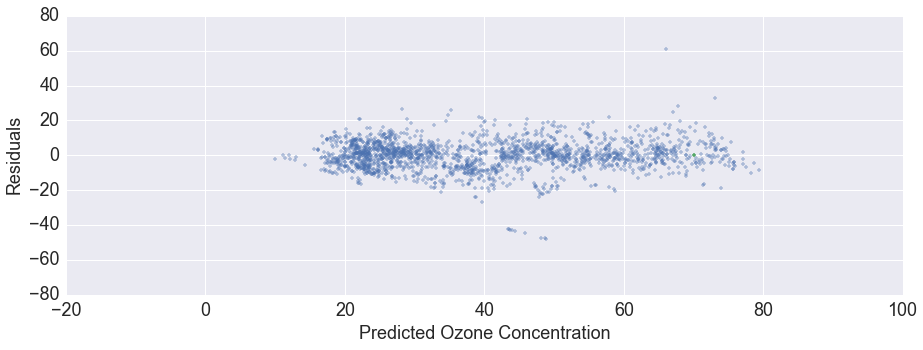

In [54]:
fitted_vs_ref_plot(df_svm_fit_all, len(all_features), ref_column)
plot_fitted_and_ref_vs_time(df_svm_fit_all, pod_number, 1, ref_column)
plot_fitted_and_ref_vs_time(df_svm_fit_all, pod_number, 2, ref_column)
plot_fitted_and_ref_vs_time(df_svm_fit_all, pod_number, 4, ref_column)
plot_fitted_and_ref_vs_time(df_svm_fit_all, pod_number, 5, ref_column)
plot_fitted_and_ref_vs_time(df_svm_fit_all, pod_number, 6, ref_column)
resid = plot_resid_vs_conc(df_svm_fit_all, ref_column)

#Random Forest- All

In [55]:
MSE_CV, df_fit_rf = find_MSE_random_forest(df_fits, fs_features[:num_good_feat], days_tr, 0, ref_column)

7-28 Cross-Validation RMSE:  11.1
7-29 Cross-Validation RMSE:  9.4
7-31 Cross-Validation RMSE:  11.4
8-1 Cross-Validation RMSE:  8.7
8-2 Cross-Validation RMSE:  8.9
8-3 Cross-Validation RMSE:  11.7
8-4 Cross-Validation RMSE:  7.4
8-5 Cross-Validation RMSE:  14.9
8-6 Cross-Validation RMSE:  9.8
8-7 Cross-Validation RMSE:  7.4
8-8 Cross-Validation RMSE:  9.2
8-9 Cross-Validation RMSE:  9.9
8-10 Cross-Validation RMSE:  8.1


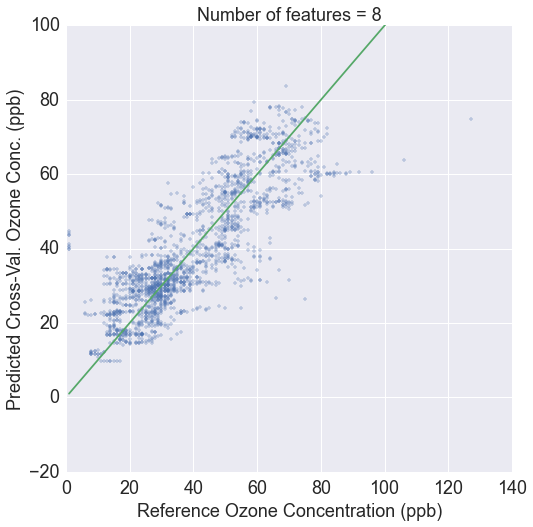

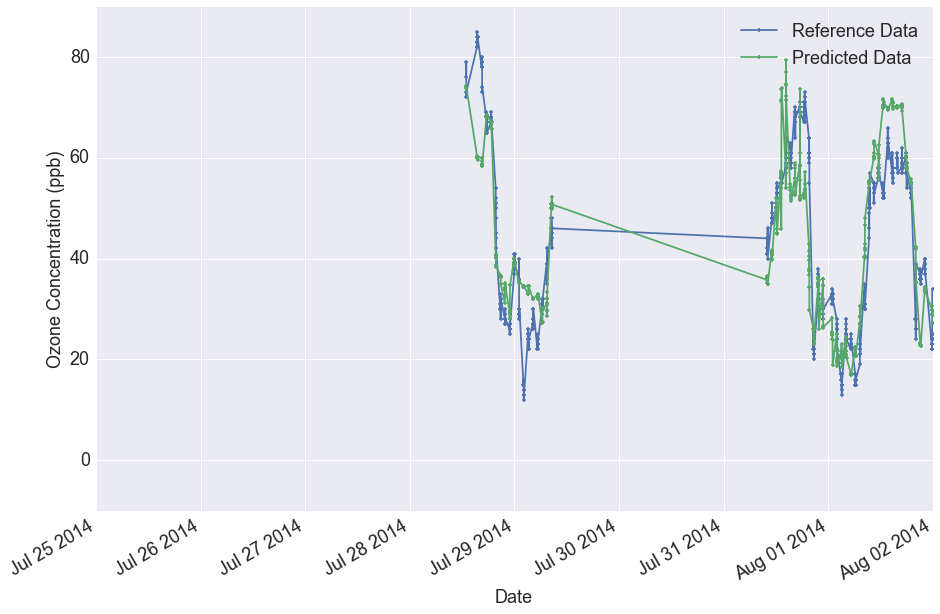

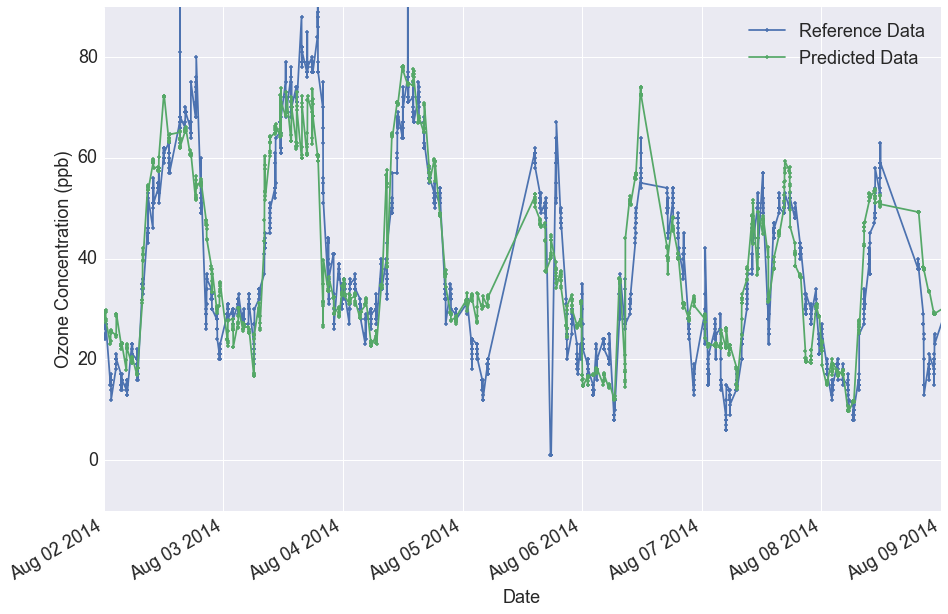

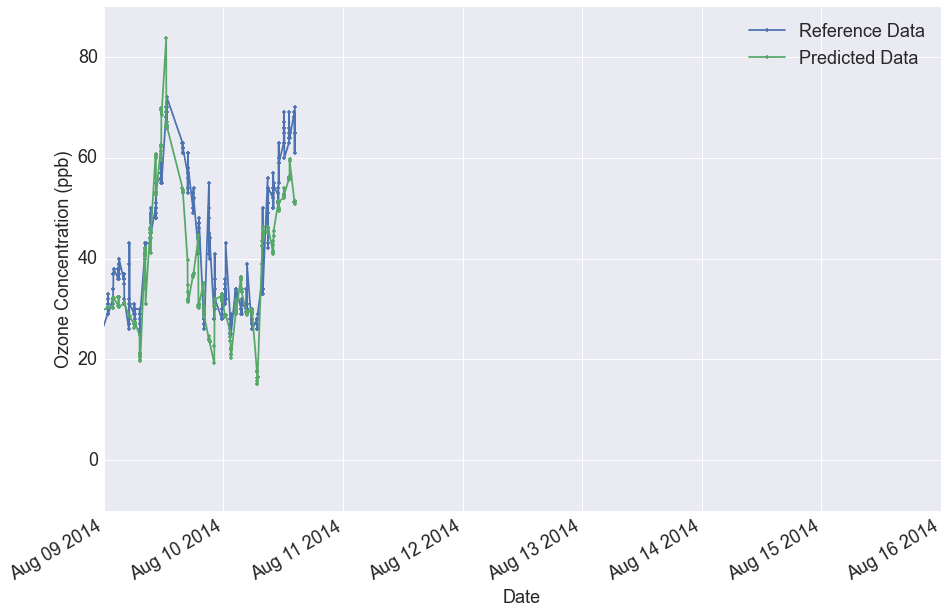

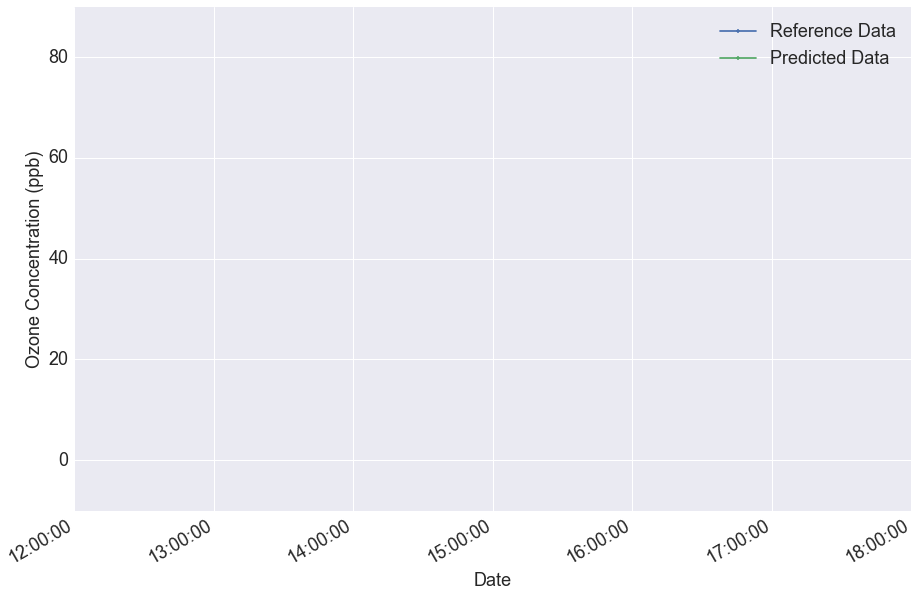

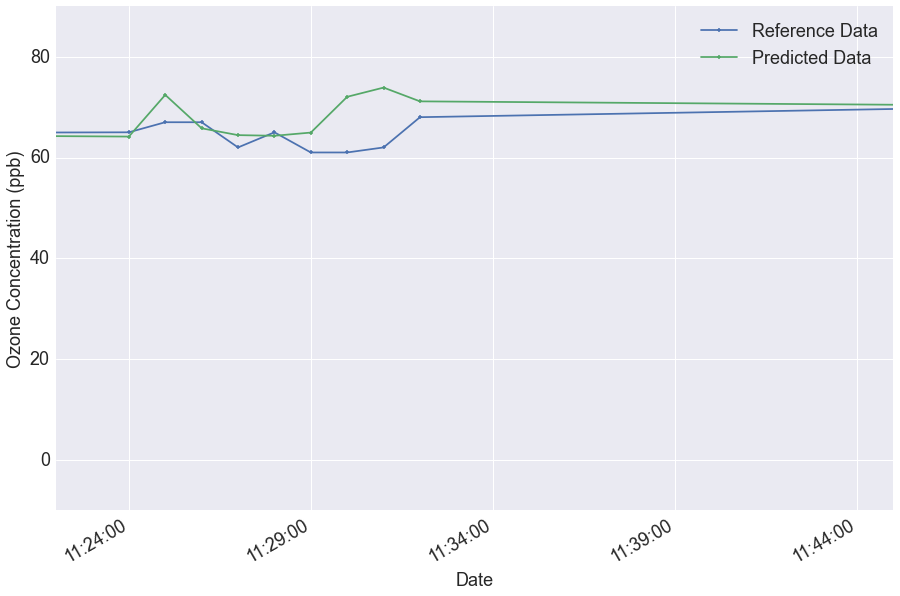

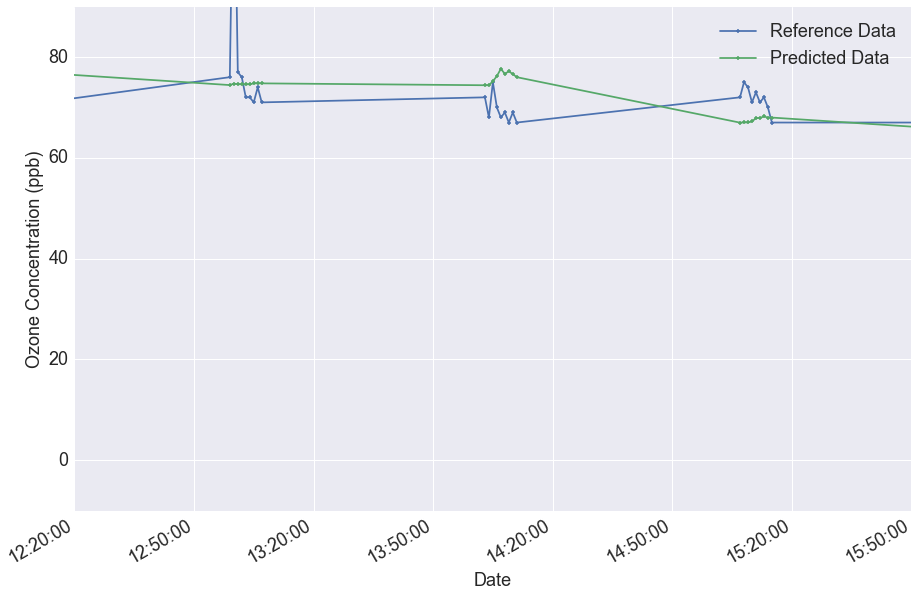

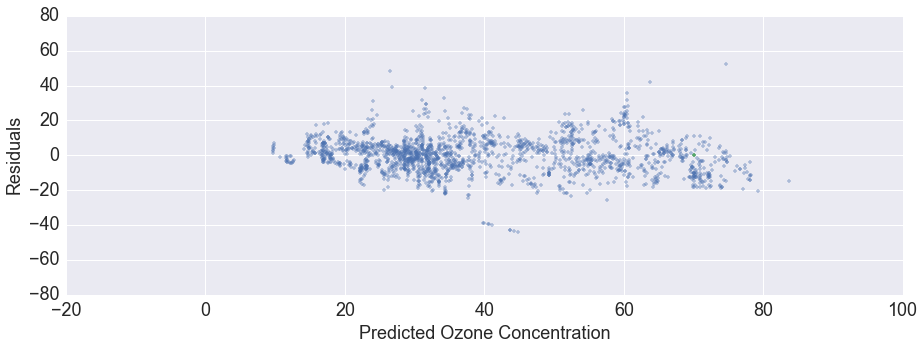

In [56]:
fitted_vs_ref_plot(df_fit_rf, num_good_feat, ref_column)
plot_fitted_and_ref_vs_time(df_fit_rf, pod_number, 1, ref_column)
plot_fitted_and_ref_vs_time(df_fit_rf, pod_number, 2, ref_column)
plot_fitted_and_ref_vs_time(df_fit_rf, pod_number, 3, ref_column)
plot_fitted_and_ref_vs_time(df_fit_rf, pod_number, 4, ref_column)
plot_fitted_and_ref_vs_time(df_fit_rf, pod_number, 5, ref_column)
plot_fitted_and_ref_vs_time(df_fit_rf, pod_number, 6, ref_column)
resid = plot_resid_vs_conc(df_fit_rf, ref_column)

## Random Forest- Base

In [57]:
MSE_CV_base, df_fit_rf_base = find_MSE_random_forest(df_fits, base_features, days_tr, 0, ref_column)

7-28 Cross-Validation RMSE:  12.8
7-29 Cross-Validation RMSE:  9.0
7-31 Cross-Validation RMSE:  12.9
8-1 Cross-Validation RMSE:  8.6
8-2 Cross-Validation RMSE:  9.2
8-3 Cross-Validation RMSE:  13.7
8-4 Cross-Validation RMSE:  8.1
8-5 Cross-Validation RMSE:  19.3
8-6 Cross-Validation RMSE:  10.4
8-7 Cross-Validation RMSE:  8.9
8-8 Cross-Validation RMSE:  9.7
8-9 Cross-Validation RMSE:  10.8
8-10 Cross-Validation RMSE:  7.0


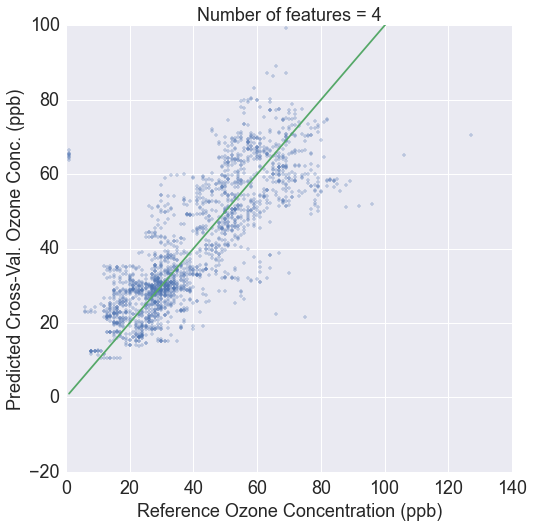

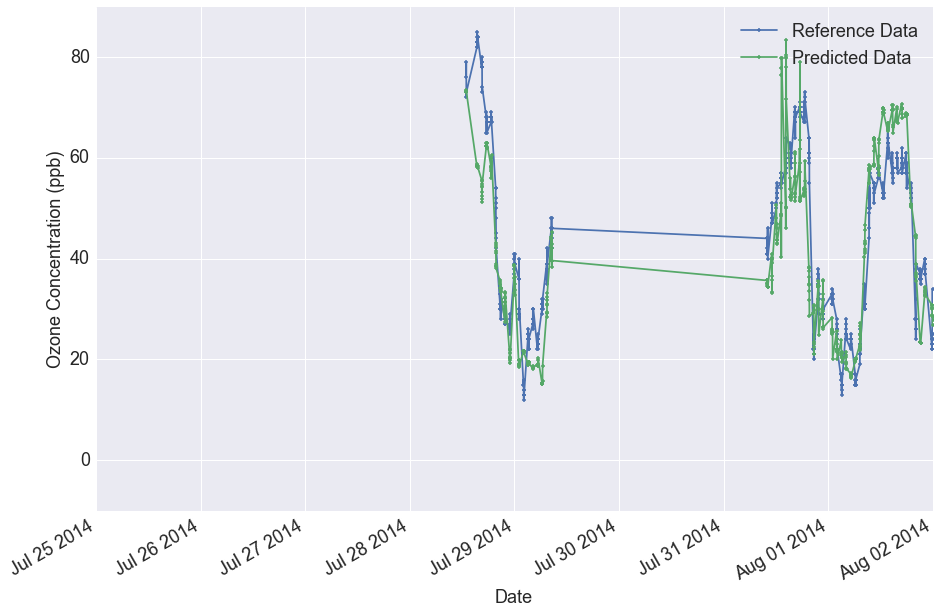

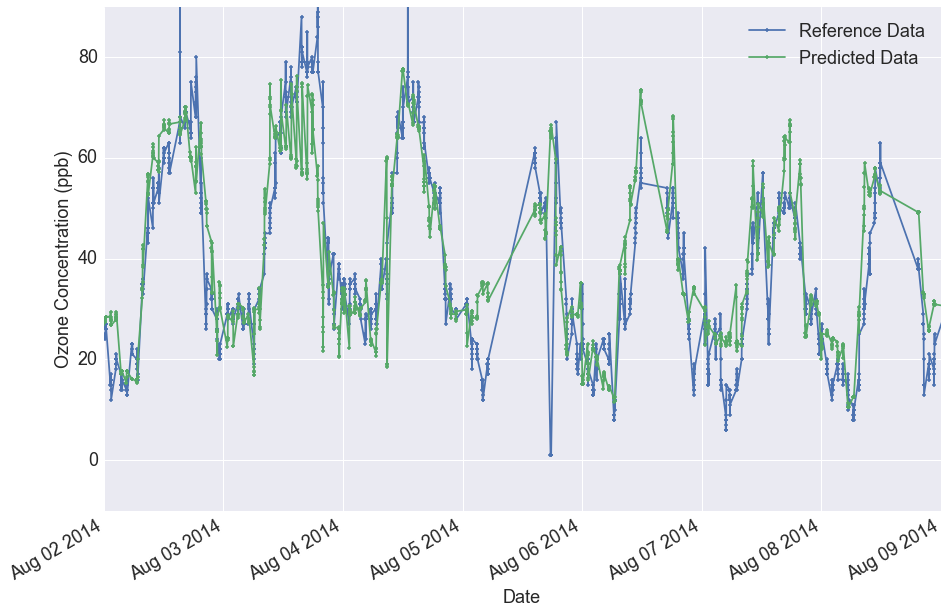

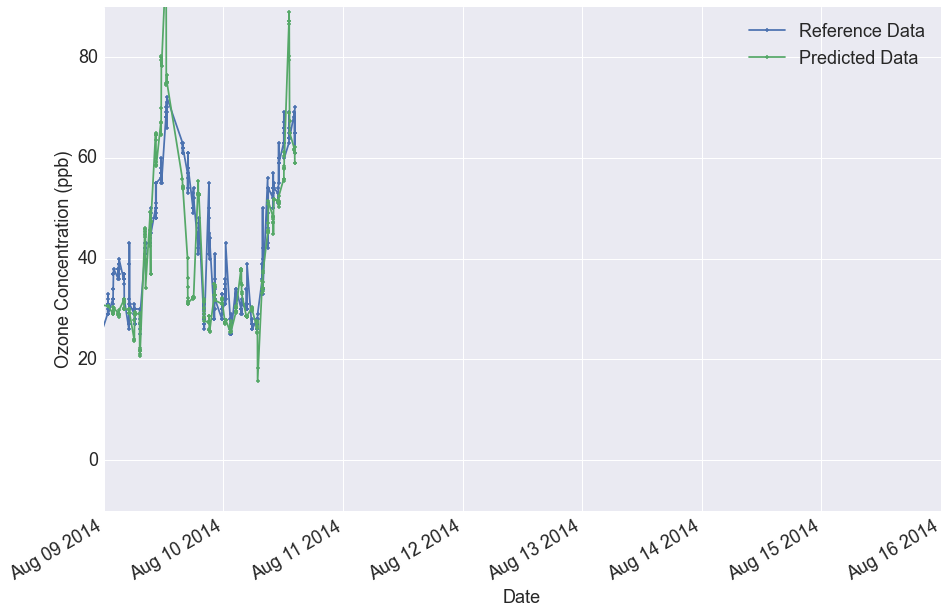

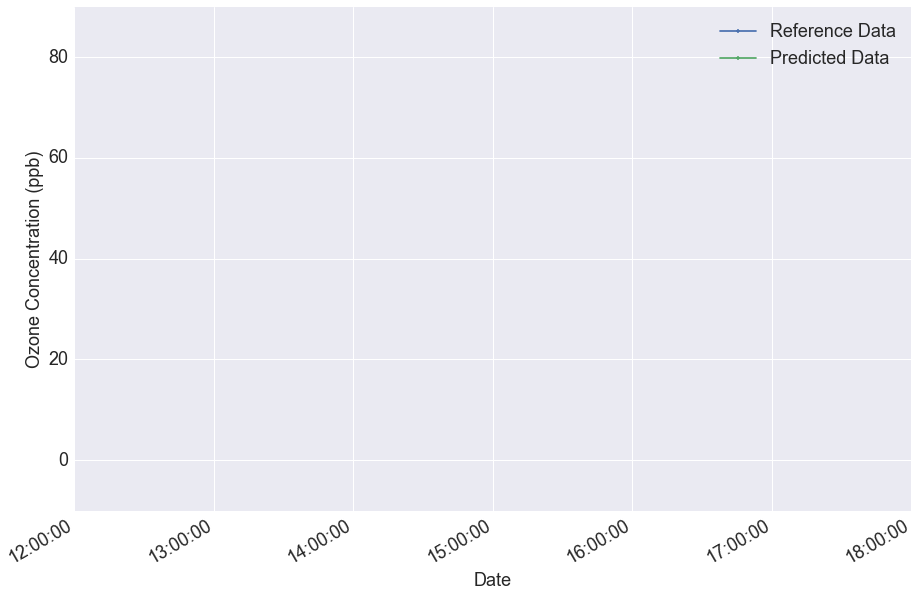

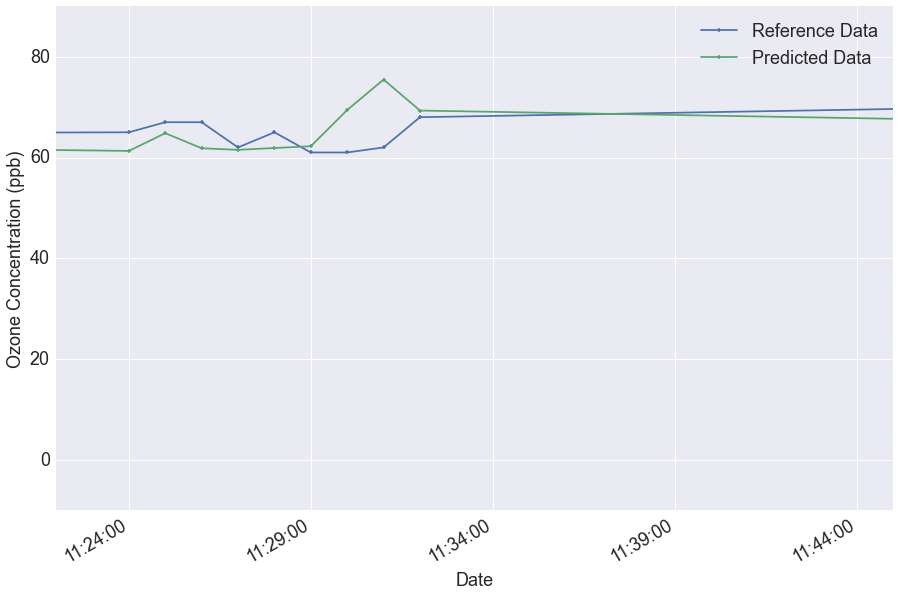

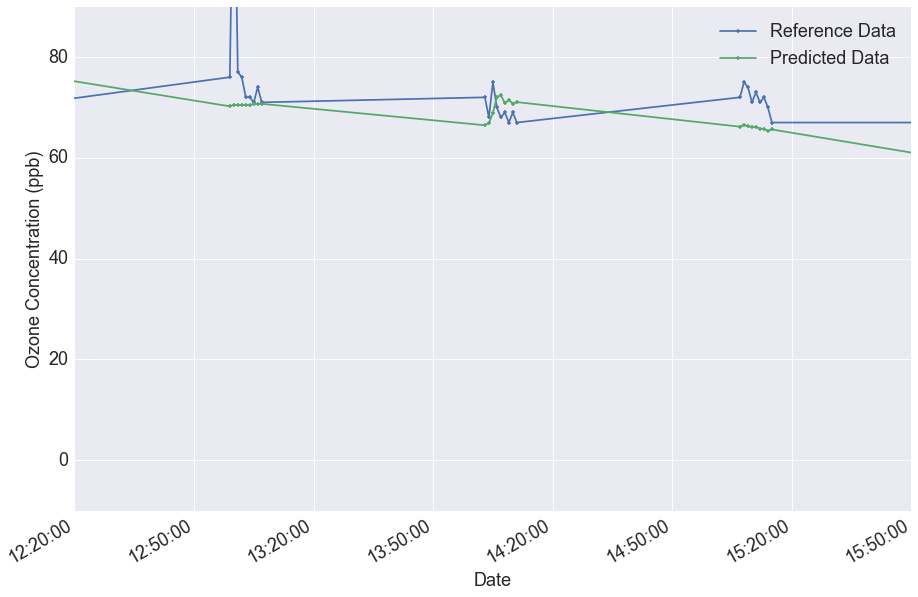

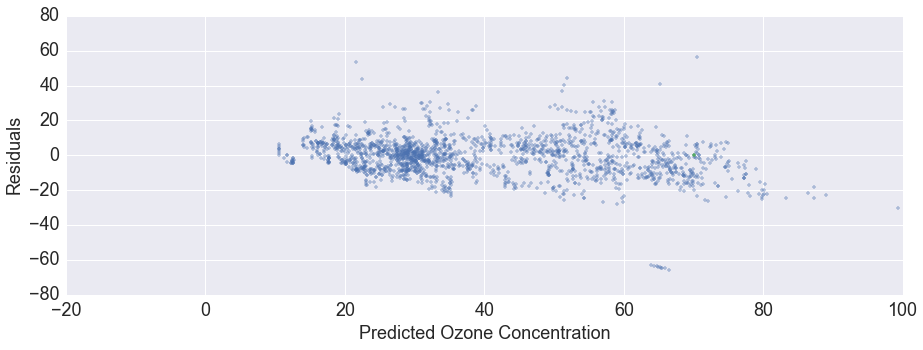

In [58]:
fitted_vs_ref_plot(df_fit_rf_base, 4, ref_column)
plot_fitted_and_ref_vs_time(df_fit_rf_base, pod_number, 1, ref_column)
plot_fitted_and_ref_vs_time(df_fit_rf_base, pod_number, 2, ref_column)
plot_fitted_and_ref_vs_time(df_fit_rf_base, pod_number, 3, ref_column)
plot_fitted_and_ref_vs_time(df_fit_rf_base, pod_number, 4, ref_column)
plot_fitted_and_ref_vs_time(df_fit_rf_base, pod_number, 5, ref_column)
plot_fitted_and_ref_vs_time(df_fit_rf_base, pod_number, 6, ref_column)
resid = plot_resid_vs_conc(df_fit_rf_base, ref_column)